In [1]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram
import geopandas as gpd
import geodatasets
import os
import zipfile
import urllib.request

from sklearn.decomposition import PCA
import seaborn as sns

## Clustering and Dimension Reduction Project on Development Indicators of almost all countries, provided by World Bank Data

Inspired by the research goal presented in the following Kaggle dataset: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data/data 

I initially intended to use this dataset directly, as both the topic and the research question are highly relevant. However, the dataset lacks sufficient documentation regarding data sources and data generation processes, making it difficult to assess its reliability. Therefore, I decided to construct the dataset independently using officially published indicators from the World Bank World Development Indicators (https://databank.worldbank.org/source/world-development-indicators) for the year 2022 - as for this year the least amount of missing values was observed, and it is quite recent. The resulting dataset includes health, policy/institution performance, and resource-related development indicators for the majority of countries worldwide. 

Some countries had to be excluded due to missing data in one or more thematic categories. Notable exclusions include Venezuela, Greenland, North Korea, South Sudan, Liechtenstein, Monaco, and several small island states. While this reduces global coverage slightly, it was necessary in order to keep internal consistency and comparability across all selected indicators. More indicators were considered (such as Gini index, or ODA support) which would be very valuable for the analysis, however too many countries had missing data for such other indicators that were considered. I spent a long time selecting the data in order to incorporate as many indicators while minimizing the reduction of countries as much as possible. 

The primary objective of this analysis is to group countries based on multidimensional development indicators using unsupervised learning techniques. Such approach will allow to identify clusters of countries with similar development profiles, particularly those that may require financial or institutional assistance, and to explore which specific areas contribute most strongly to these groupings.

List of all countries excluded from the analysis due to lack of data:
Aruba,
American Samoa,
Bermuda,
Cayman Islands,
Channel Islands,
Curacao,
Cuba,
Eritrea,
Faroe Islands,
British Virgin Islands,
French Polynesia,
Gibraltar,
Greenland,
Guam,
Hong Kong SAR, 
Isle of Man,
Korea Dem. People's Rep.,
Kosovo,
Liechtenstein,
Macao SAR,
Monaco,
Nauru,
New Caledonia,
Northern Mariana Islands,
Puerto Rico (US),
South Sudan,
Turks and Caicos Islands,
Tuvalu,
Venezuela, 
Virgin Islands (U.S.),
Yemen.

# Part I - Clustering

# Chapter I - Data handling

In [2]:
raw = pd.read_csv("data/development_indicators.csv")

In [3]:
raw

,Country Name,Country Code,Series Name,Series Code,2022 [YR2022]
0,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.544956
1,Afghanistan,AFG,Voice and Accountability: Estimate,VA.EST,-1.753529
2,Afghanistan,AFG,Rule of Law: Estimate,RL.EST,-1.659846
3,Afghanistan,AFG,Regulatory Quality: Estimate,RQ.EST,-1.271806
4,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-1.880035
...,...,...,...,...,...
2024,NaN,NaN,NaN,NaN,NaN
2025,NaN,NaN,NaN,NaN,NaN
2026,NaN,NaN,NaN,NaN,NaN
2027,Data from database: World Development Indicators,NaN,NaN,NaN,NaN


In [4]:
raw = raw.drop(raw.tail(5).index)
raw

,Country Name,Country Code,Series Name,Series Code,2022 [YR2022]
0,Afghanistan,AFG,Political Stability and Absence of Violence/Te...,PV.EST,-2.544956
1,Afghanistan,AFG,Voice and Accountability: Estimate,VA.EST,-1.753529
2,Afghanistan,AFG,Rule of Law: Estimate,RL.EST,-1.659846
3,Afghanistan,AFG,Regulatory Quality: Estimate,RQ.EST,-1.271806
4,Afghanistan,AFG,Government Effectiveness: Estimate,GE.EST,-1.880035
...,...,...,...,...,...
2019,Zimbabwe,ZWE,Lifetime risk of maternal death (%),SH.MMR.RISK.ZS,1.346997
2020,Zimbabwe,ZWE,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,62.360000
2021,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,50.100000
2022,Zimbabwe,ZWE,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,42.200000


In [5]:
wide = raw.pivot_table(
    index=["Country Name", "Country Code"],
    columns="Series Code",
    values="2022 [YR2022]",
    aggfunc="first"
).reset_index()

rename = {
    "EG.ELC.ACCS.ZS": "electricity_access",
    "SP.DYN.LE00.IN": "life_expectancy",
    "SP.DYN.IMRT.IN": "infant_mortality_per_1000",
    "SH.MMR.RISK.ZS": "maternal_death_risk_pct",
    "AG.LND.ARBL.HA.PC": "arable_land_ha_per_person",
    "VA.EST": "wgi_voice_and_accountabillity",
    "PV.EST": "wgi_political_stability_and_absence_of_terrorism",
    "GE.EST": "wgi_government_effectiveness",
    "RQ.EST": "wgi_regulatory_quality",
    "RL.EST": "wgi_rule_of_law",
    "CC.EST": "wgi_control_of_corruption",
}
wide = wide.rename(columns=rename)

In [6]:
wide

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529
1,Albania,ALB,0.243960,-0.408189,100.0,0.064541,0.106261,-0.165585,0.159354,0.010570,8.3,78.769,0.141740
2,Algeria,DZA,0.165599,-0.638041,100.0,-0.513499,-0.650652,-0.833260,-1.063573,0.169461,20.0,76.129,-1.011919
3,Andorra,AND,0.009380,1.270272,100.0,1.495261,1.585988,1.485483,1.398334,0.014257,2.6,84.016,1.106789
4,Angola,AGO,0.151115,-0.612376,48.5,-1.026034,-0.630109,-1.022036,-0.606699,0.966423,39.6,64.246,-0.807578
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Vanuatu,VUT,0.063888,-0.028580,71.6,-0.538525,0.961862,0.322184,-0.090816,0.397198,14.4,71.302,0.585711
180,Viet Nam,VNM,0.067746,-0.287254,100.0,0.174635,-0.046132,-0.158469,-0.429956,0.083527,14.3,74.502,-1.286407
181,West Bank and Gaza,PSE,0.008308,-0.702708,100.0,-0.902029,-1.701955,-0.555172,-0.036869,0.059103,12.3,76.662,-1.035614
182,Zambia,ZMB,0.188558,-0.504948,47.8,-0.638017,0.161332,-0.517024,-0.529058,0.384520,32.2,65.279,-0.079451


### Last 5 rows were dropped as they are not relevant for the analysis. Due to the nature of the dataset, or rather how it is generated from the World Bank database, it had to be pivoted, in order to transform all the indicators as columns (variables). This convention allows us to get a dataset in which every row represents a country with values of all the selected indicators.



# Variables:
- arable_land_ha_per_person - Arable land per person (ha)
- electricity_access - Fraction of population having access to electricity (%)
- life_expectancy - life expectancy in years
- infant_mortality_per_1000 - infant deaths per 1000 births
- maternal_death_risk_pct - Probability that a 15-year-old female will die eventually from a maternal cause assuming that current levels of fertility and mortality do not change in the future (%)

#### Worldwide Governance Indicators (WGI) are reflection of the views on the quality of governance provided by enterprises, citizen and expert survey respondents - with values ranging from -2.5 (worst) to 2.5 (best):
- wgi_control_of_corruption - WGI indicator measuring the perception on the extent and severity of corruption in the country.
- wgi_government_effectiveness - WGI indicator capturing the perception and views of the quality of public services, its independence from political pressures, policy implementation, and credibillity of the government's commitment to such policies.
- wgi_regulatory_quality - WGI indicator measuring the perception on the quality of policies implemented by the government.
- wgi_political_stability_and_absence_of_terrorism - WDI indicator which describes the population's view on on the process of government selection, monitoring and replacement and the presence of terrorism.
- wgi_rule_of_law - WGI indicator describing the perception about the quality of the law and whether government bodies are are accountable and if needed, enforced according to such laws.
- wgi_voice_and_accountabillity - WGI indicator measuring the respect of citizens and the state for the institutions that govern economic and social interactions among them and population perceived freedom.

In [7]:
wide.isna().mean()

Series Code
Country Name                                        0.0
Country Code                                        0.0
arable_land_ha_per_person                           0.0
wgi_control_of_corruption                           0.0
electricity_access                                  0.0
wgi_government_effectiveness                        0.0
wgi_political_stability_and_absence_of_terrorism    0.0
wgi_rule_of_law                                     0.0
wgi_regulatory_quality                              0.0
maternal_death_risk_pct                             0.0
infant_mortality_per_1000                           0.0
life_expectancy                                     0.0
wgi_voice_and_accountabillity                       0.0
dtype: float64

In [8]:
wide.describe()

Series Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,0.191609,-0.054274,86.521196,-0.053966,-0.084721,-0.047843,-0.041983,0.444675,19.984239,72.437435,-0.022392
std,0.224966,0.983686,23.585344,0.952824,0.962735,0.957007,0.937209,0.810218,21.265126,7.989915,0.971181
min,0.000099,-1.792611,10.300000,-2.228161,-2.776898,-2.287279,-2.089348,0.001167,1.400000,18.818000,-1.946265
25%,0.059255,-0.767299,84.400000,-0.765052,-0.629996,-0.757770,-0.714083,0.018239,5.075000,67.404750,-0.854022
50%,0.119383,-0.297659,100.000000,-0.106993,-0.018716,-0.162027,-0.150161,0.090092,13.200000,73.417000,0.021517
75%,0.232642,0.565911,100.000000,0.566299,0.727070,0.630636,0.551190,0.410638,30.900000,77.506152,0.849697
max,1.480922,2.402638,100.000000,2.144236,1.585988,1.957900,2.214378,4.528834,189.100000,85.708000,1.780675


In [9]:
wide.dtypes

Series Code
Country Name                                         object
Country Code                                         object
arable_land_ha_per_person                           float64
wgi_control_of_corruption                           float64
electricity_access                                  float64
wgi_government_effectiveness                        float64
wgi_political_stability_and_absence_of_terrorism    float64
wgi_rule_of_law                                     float64
wgi_regulatory_quality                              float64
maternal_death_risk_pct                             float64
infant_mortality_per_1000                           float64
life_expectancy                                     float64
wgi_voice_and_accountabillity                       float64
dtype: object

### The dataset does not require transformations in terms of data types. However, an inspection of descriptive statistics reveals substantial differences in scale and dispersion across variables. Since distance-based methods such as K-means clustering are sensitive to the relative scaling of input features, an appropriate scaling procedure is required prior to further analysis. Since all the numeric variables are either taking values between 0 and 1, -2.5 to 2.5, or 0 and 100, standarization will be used.

In [10]:
features = [
    "electricity_access",
    "life_expectancy",
    "infant_mortality_per_1000",
    "maternal_death_risk_pct",
    "arable_land_ha_per_person",
    "wgi_voice_and_accountabillity",
    "wgi_political_stability_and_absence_of_terrorism",
    "wgi_government_effectiveness",
    "wgi_regulatory_quality",
    "wgi_rule_of_law",
    "wgi_control_of_corruption",
]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(wide[features])

x_scaled = pd.DataFrame(x_scaled, columns=features, index=wide.index)

data_scaled = pd.concat([wide[["Country Name", "Country Code"]], x_scaled], axis=1)

In [11]:
data_scaled

,Country Name,Country Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
0,Afghanistan,AFG,-0.051919,-0.855960,1.509660,2.750825,0.003816,-1.787370,-2.562439,-1.921711,-1.315798,-1.689016,-1.151273
1,Albania,ALB,0.573050,0.794607,-0.550955,-0.537249,0.233341,0.169464,0.198916,0.124713,0.215412,-0.123367,-0.360766
2,Algeria,DZA,0.573050,0.463289,0.000743,-0.340605,-0.115932,-1.021670,-0.589442,-0.483602,-1.093008,-0.822940,-0.595068
3,Andorra,AND,0.573050,1.453102,-0.819730,-0.532686,-0.812239,1.165861,1.740114,1.630368,1.541008,1.606581,1.350187
4,Angola,AGO,-1.616467,-1.028019,0.924955,0.645717,-0.180488,-0.810692,-0.568044,-1.022981,-0.604194,-1.020735,-0.568905
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Vanuatu,VUT,-0.634373,-0.142496,-0.263317,-0.058757,-0.569280,0.627857,1.090060,-0.509938,-0.052247,0.387705,0.026192
180,Viet Nam,VNM,0.573050,0.259101,-0.268033,-0.446957,-0.552084,-1.305075,0.040192,0.240574,-0.415096,-0.115912,-0.237490
181,West Bank and Gaza,PSE,0.573050,0.530180,-0.362340,-0.477185,-0.817017,-1.046135,-1.684418,-0.892481,0.005472,-0.531567,-0.660986
182,Zambia,ZMB,-1.646228,-0.898378,0.576018,-0.074448,-0.013597,-0.058912,0.256274,-0.614641,-0.521125,-0.491596,-0.459398


### In order to verify wheter the data is even clusterable, Hopkins statistic will be calculated. Since none of the Python packages have this functionality, function specifed here will be used: https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb  

In [12]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [13]:
np.random.seed(111)
random.seed(111)
hopkins_statistic(x_scaled)

0.8445107269686581

### With Hopkins statistic at ~0.85, the null hypothesis that the dataset is uniformly distributed may be rejected in favor of the alternative hypothesis, stating that the distribution is not uniform. This suggests that the dataset has a tendency to cluster - which is a great information for further analysis.

# Chapter II - Determining the Number of Clusters

In the analysis, I intend to use the K-means, PAM and hierarchichal (agglomerative) clustering methods to group countries based on the transformed indicators. This chapter is dedicated for finding the appropiate amount of clusters for each of the approaches. Elbow plots, average silhouette analysis (higher the value, the more observations of a given cluster are simillar to each other and different to observations of other clusters) and Calinski-Harabasz indexes (measuring whether clustering result consists of compact, well-seperated clusters - similar to silhouette width) among others will be analyzed.

# Analysis for choosing the correct amount of clusters for K-means algorithm

In [14]:
silhouettes = []
calinski_harabasz_scores = []
distortions = []

k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=111, n_init=50)
    labels = kmeans.fit_predict(x_scaled)

    silhouettes.append(silhouette_score(x_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(x_scaled, labels))
    distortions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve for K-means')

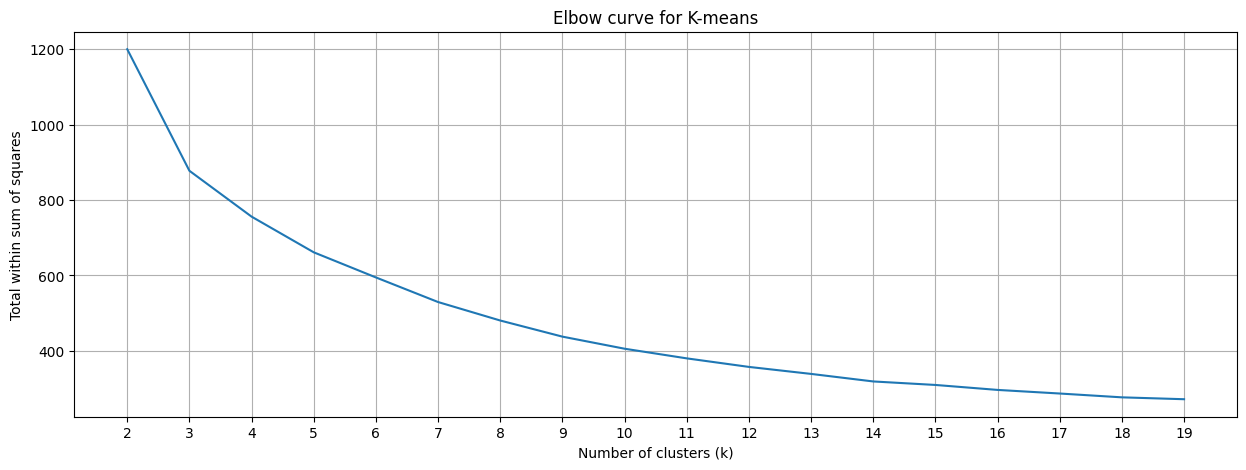

In [15]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distortions)
plt.xticks(k_range)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Total within sum of squares")
plt.grid(True)
plt.title('Elbow curve for K-means')

In [16]:
for k, val in zip(k_range, distortions):
    print(f"k = {k}: WSS = {val}")

k = 2: WSS = 1199.4712095563077
k = 3: WSS = 877.4122034564962
k = 4: WSS = 755.9237828735799
k = 5: WSS = 661.4047650854808
k = 6: WSS = 594.8420455385137
k = 7: WSS = 529.6618547551353
k = 8: WSS = 480.704935095666
k = 9: WSS = 437.9979422025236
k = 10: WSS = 405.99052235901934
k = 11: WSS = 380.41566352152506
k = 12: WSS = 357.78908755569154
k = 13: WSS = 339.2438448055375
k = 14: WSS = 319.26234774285
k = 15: WSS = 309.9827819603235
k = 16: WSS = 296.83126538770455
k = 17: WSS = 287.2883945680747
k = 18: WSS = 277.15971555488716
k = 19: WSS = 272.1766670739409


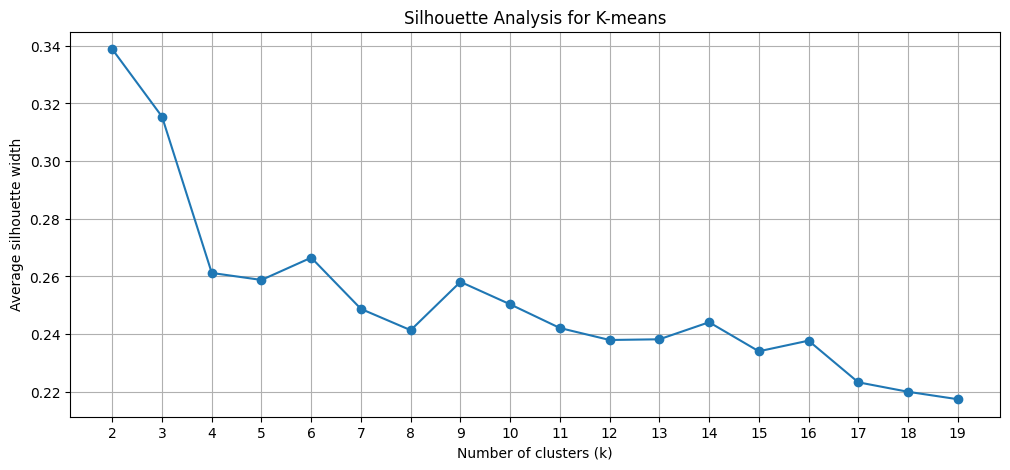

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(k_range, silhouettes, marker='o')
plt.xticks(k_range)    
plt.grid(True)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette width")
plt.title("Silhouette Analysis for K-means")
plt.show()

In [18]:
for k, val in zip(k_range, silhouettes):
    print(f"k = {k}: Average silhouette width = {val}")

k = 2: Average silhouette width = 0.3388190448361285
k = 3: Average silhouette width = 0.3154185334999694
k = 4: Average silhouette width = 0.2612083101553281
k = 5: Average silhouette width = 0.25877779192830325
k = 6: Average silhouette width = 0.26651076088916664
k = 7: Average silhouette width = 0.24872800428469263
k = 8: Average silhouette width = 0.24134747709127205
k = 9: Average silhouette width = 0.25811256043327696
k = 10: Average silhouette width = 0.2503258472941935
k = 11: Average silhouette width = 0.242105574404343
k = 12: Average silhouette width = 0.23795188106490853
k = 13: Average silhouette width = 0.23819236237931998
k = 14: Average silhouette width = 0.24411090081310913
k = 15: Average silhouette width = 0.2340276109629043
k = 16: Average silhouette width = 0.23772263478257302
k = 17: Average silhouette width = 0.22326883134104916
k = 18: Average silhouette width = 0.21998326105506866
k = 19: Average silhouette width = 0.21740221165675322


In [19]:
for k, val in zip(k_range, calinski_harabasz_scores):
    print(f"k = {k}: Calinski-Harabasz index = {val}")

k = 2: Calinski-Harabasz index = 125.10866343866789
k = 3: Calinski-Harabasz index = 118.26390740681327
k = 4: Calinski-Harabasz index = 100.6511168868853
k = 5: Calinski-Harabasz index = 92.19186189948918
k = 6: Calinski-Harabasz index = 85.53198880346253
k = 7: Calinski-Harabasz index = 83.22852568853241
k = 8: Calinski-Harabasz index = 80.72071766528435
k = 9: Calinski-Harabasz index = 79.20994979989639
k = 10: Calinski-Harabasz index = 77.04986901162988
k = 11: Calinski-Harabasz index = 74.74458006766258
k = 12: Calinski-Harabasz index = 72.817983074459
k = 13: Calinski-Harabasz index = 70.76849168857554
k = 14: Calinski-Harabasz index = 69.82571951408713
k = 15: Calinski-Harabasz index = 66.7476957491561
k = 16: Calinski-Harabasz index = 65.16931362466578
k = 17: Calinski-Harabasz index = 63.09662250349076
k = 18: Calinski-Harabasz index = 61.543509549728675
k = 19: Calinski-Harabasz index = 58.999842728839454


### The Calinski-Harabasz index peaks at k = 2, decreasing with each k increase, although difference between k = 2 and k = 3 is minimal. Nontheless k = 3 is preferred, as a pronounced elbow in within-cluster sum of squares is visible for such k value - as reduction in within-cluster variance achieved by increasing k from 2 to 3 is notably larger than mariginal improvements observed for higher vlaues of k. Average silhouette width is the highest for k = 2 at 0.33, however for k = 3 it is not substantially less, as it is equal to 0.315.

While those silhouette values are not fully satisfactory - given that values above 0.5 are typically considered indicative of strong clustering and those above oreequal to 0.25 reflect weak structure - result for k = 3 may be classified as moderate. However, it is important to note, that it is not invalidating the analysis.

It is also worth mentioning that during my previous attempt at clustering, I included more variables and average silhouette width values were high, however end results of clustering unsatisfactory due to the scale of those dominating variables (GDP per capita PPP, number of scientific journals, foreign direct investment as % of GDP - despite rescaling the data using RobustScaler). Therefore, my final decision is to select k = 3 for the K-means algorithm. Hopefully, it will group countries in a simillar manner to to the convention of most developed/developing/least developed countries grouping, in a manner that is relevant to the stated research question. Alternatively, the clustering may distinguish countries that are both well-developed in for e.g. institutional and healthcare dimensions from those that exhibit development in only one - or neither - of these areas. Either outcome would meaningfully contribute to adressing the explanatory ("how") aspect of the research question.

# Analysis for choosing the correct amount of clusters for PAM algorithm

In [20]:
silhouettes = []
calinski_harabasz_scores = []
dissimilarities = [] 

k_range = range(2, 20)

for k in k_range:
    pam = KMedoids(n_clusters=k, method="pam", metric="euclidean", init="k-medoids++", random_state=111)
    labels = pam.fit_predict(x_scaled)

    silhouettes.append(silhouette_score(x_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(x_scaled, labels))
    dissimilarities.append(pam.inertia_)

Text(0.5, 1.0, 'Elbow curve for PAM')

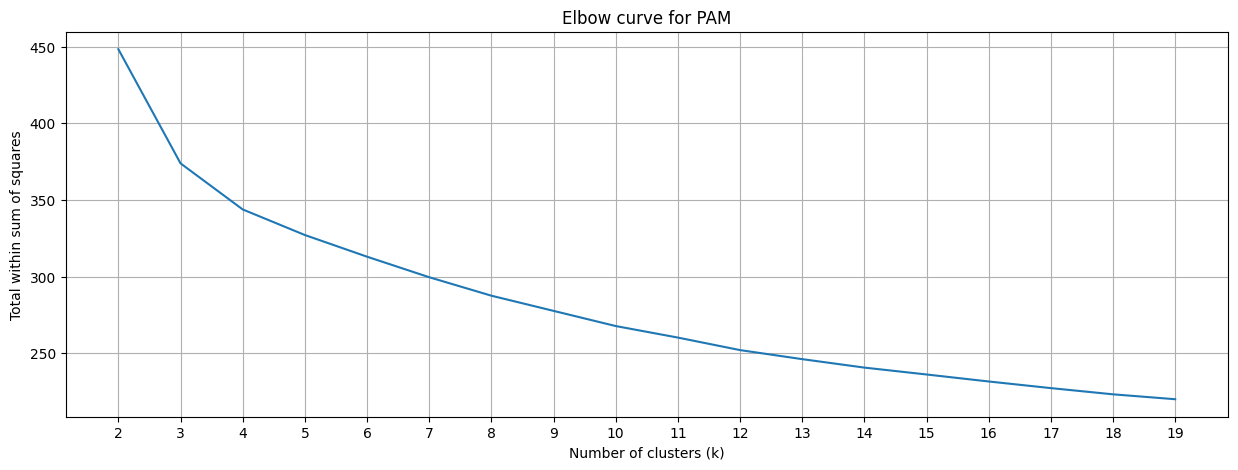

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), dissimilarities)
plt.xticks(k_range)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Total within sum of squares")
plt.grid(True)
plt.title('Elbow curve for PAM')

In [22]:
for k, val in zip(k_range, dissimilarities):
    print(f"k = {k}: Total within-cluster dissimilarity (sum of distances to medoids) = {val}")

k = 2: Total within-cluster dissimilarity (sum of distances to medoids) = 448.23032919260453
k = 3: Total within-cluster dissimilarity (sum of distances to medoids) = 373.8275245379358
k = 4: Total within-cluster dissimilarity (sum of distances to medoids) = 343.7815045709694
k = 5: Total within-cluster dissimilarity (sum of distances to medoids) = 327.10376846808833
k = 6: Total within-cluster dissimilarity (sum of distances to medoids) = 312.97565702387885
k = 7: Total within-cluster dissimilarity (sum of distances to medoids) = 299.585284991266
k = 8: Total within-cluster dissimilarity (sum of distances to medoids) = 287.549623548309
k = 9: Total within-cluster dissimilarity (sum of distances to medoids) = 277.6502175071301
k = 10: Total within-cluster dissimilarity (sum of distances to medoids) = 267.7598782451472
k = 11: Total within-cluster dissimilarity (sum of distances to medoids) = 260.2398986525136
k = 12: Total within-cluster dissimilarity (sum of distances to medoids) = 25

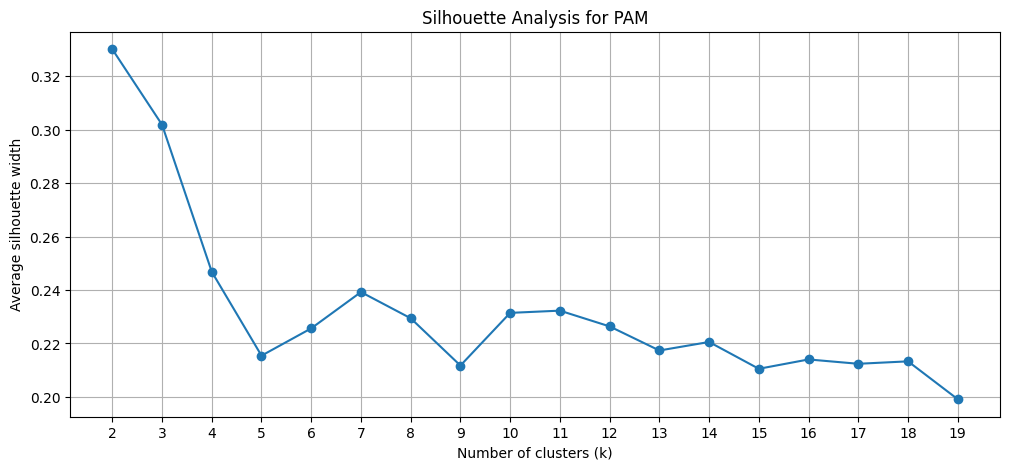

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(k_range, silhouettes, marker='o')
plt.xticks(k_range)    
plt.grid(True)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette width")
plt.title("Silhouette Analysis for PAM")
plt.show()

In [24]:
for k, val in zip(k_range, silhouettes):
    print(f"k = {k}: Average silhouette width = {val}")

k = 2: Average silhouette width = 0.3301340842890671
k = 3: Average silhouette width = 0.30187873209567745
k = 4: Average silhouette width = 0.24682334573168574
k = 5: Average silhouette width = 0.21541976333836596
k = 6: Average silhouette width = 0.22564215493616507
k = 7: Average silhouette width = 0.23923025597273492
k = 8: Average silhouette width = 0.22941902997766012
k = 9: Average silhouette width = 0.21172057705862615
k = 10: Average silhouette width = 0.23143690371775535
k = 11: Average silhouette width = 0.2322707749686945
k = 12: Average silhouette width = 0.2263741800957917
k = 13: Average silhouette width = 0.21735341146569737
k = 14: Average silhouette width = 0.22054280743853452
k = 15: Average silhouette width = 0.21050587071492166
k = 16: Average silhouette width = 0.21400004129401626
k = 17: Average silhouette width = 0.21237982341109143
k = 18: Average silhouette width = 0.2132912414930894
k = 19: Average silhouette width = 0.19911321038731483


In [25]:
for k, val in zip(k_range, calinski_harabasz_scores):
    print(f"k = {k}: Calinski-Harabasz index = {val}")

k = 2: Calinski-Harabasz index = 116.80603042241006
k = 3: Calinski-Harabasz index = 114.99686830031132
k = 4: Calinski-Harabasz index = 95.02914445585888
k = 5: Calinski-Harabasz index = 82.4885884907196
k = 6: Calinski-Harabasz index = 74.98813125232118
k = 7: Calinski-Harabasz index = 78.92662778167443
k = 8: Calinski-Harabasz index = 72.43065753160816
k = 9: Calinski-Harabasz index = 67.45829961115724
k = 10: Calinski-Harabasz index = 68.73208368654272
k = 11: Calinski-Harabasz index = 67.31478467789371
k = 12: Calinski-Harabasz index = 70.3306465266293
k = 13: Calinski-Harabasz index = 68.20304212238152
k = 14: Calinski-Harabasz index = 66.05424135998913
k = 15: Calinski-Harabasz index = 63.79597720021352
k = 16: Calinski-Harabasz index = 61.24499177071629
k = 17: Calinski-Harabasz index = 60.06776129304505
k = 18: Calinski-Harabasz index = 59.09886540876121
k = 19: Calinski-Harabasz index = 57.064968908396985


### The results of the analysis aimed at identifying an appropriate number of clusters for PAM clustering reveals simillar conclusions as in the K-means analysis.

Average silhouette and Calinski-Harabasz indexes are highest at k = 2, however the drop between two and three clusters chosen is minimal. Again, 'elbow' is most pronounced at k = 3, therefore k = 3 will be chosen, as it was during K-means analysis. 


# Analysis for the Hierarchichal agglomerative algorithm

For the agglomerative hierarchichal algorithm, Ward linkage will be used. Due to restrictions of Python packages, which do not feature hierarchichal divisive algorithm - analysis and implementation will be performed only for agglomerative hierarchichal algorithm.

In [26]:
agglomerative = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric = 'euclidean', compute_full_tree = 'auto', linkage = 'ward').fit(x_scaled)

## Code in this and next cell was taken, with minor tweaking, from scikit documentation (https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)


In [27]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

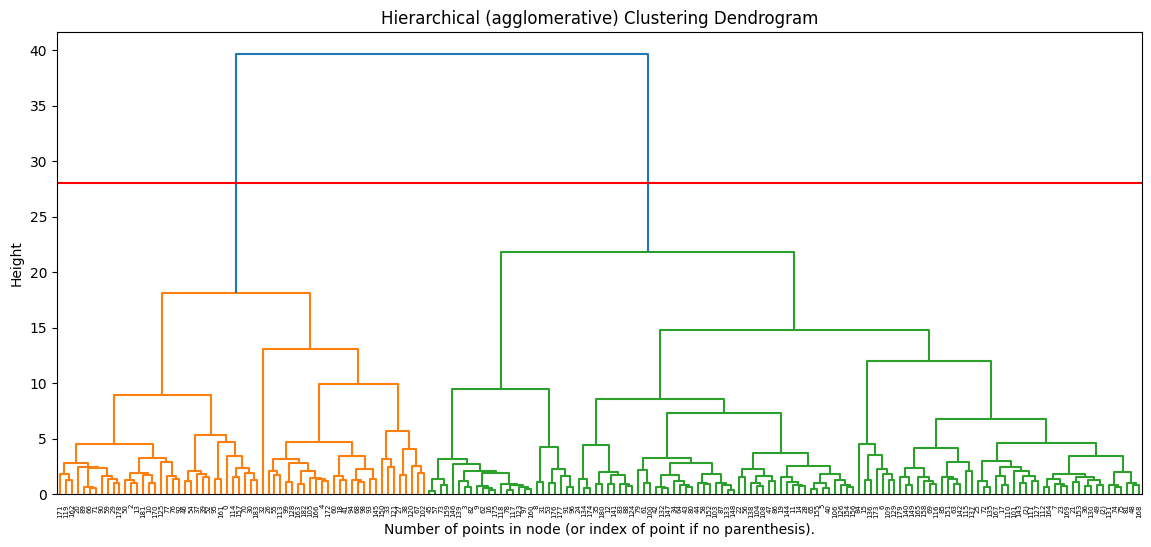

In [28]:
plt.figure(figsize=(14, 6))
plt.title("Hierarchical (agglomerative) Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglomerative, truncate_mode="level", p=10)
plt.axhline(28,color='red')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Height")
plt.show()

In [29]:
silhouettes = []
calinski_harabasz_scores = []
k_range = range(2, 20)

for k in k_range:
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward",
        metric="euclidean"
    )
    labels = model.fit_predict(x_scaled)
    silhouettes.append(silhouette_score(x_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(x_scaled, labels))

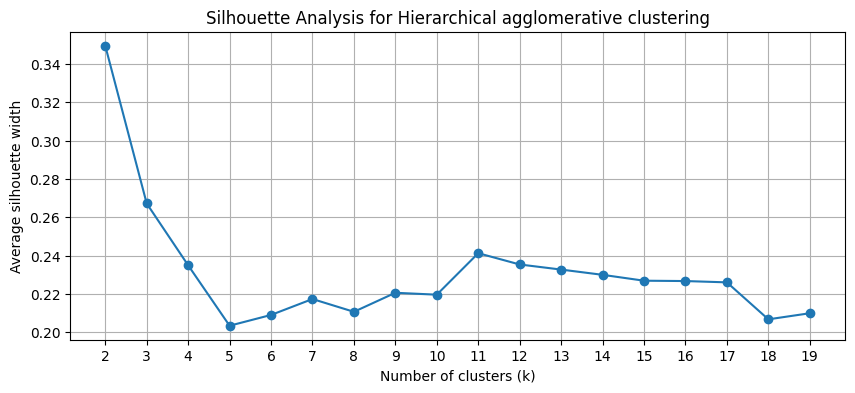

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(k_range, silhouettes, marker="o")
plt.xticks(k_range)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette width")
plt.title("Silhouette Analysis for Hierarchical agglomerative clustering")
plt.grid(True)
plt.show()

In [31]:
for k, val in zip(k_range, silhouettes):
    print(f"k = {k}: Average silhouette width = {val}")

k = 2: Average silhouette width = 0.349425032343954
k = 3: Average silhouette width = 0.2671827698250132
k = 4: Average silhouette width = 0.23494783071829414
k = 5: Average silhouette width = 0.20343442060998848
k = 6: Average silhouette width = 0.20904827482522909
k = 7: Average silhouette width = 0.2173551707073497
k = 8: Average silhouette width = 0.21068914799722935
k = 9: Average silhouette width = 0.2206124942314617
k = 10: Average silhouette width = 0.2196188474363773
k = 11: Average silhouette width = 0.24124834333209103
k = 12: Average silhouette width = 0.23536488290783789
k = 13: Average silhouette width = 0.23270980264003197
k = 14: Average silhouette width = 0.229971525102184
k = 15: Average silhouette width = 0.22690479842914033
k = 16: Average silhouette width = 0.22672569415634208
k = 17: Average silhouette width = 0.2260405924100224
k = 18: Average silhouette width = 0.20676570447257533
k = 19: Average silhouette width = 0.2099433249036846


In [32]:
for k, val in zip(k_range, calinski_harabasz_scores):
    print(f"k = {k}: Calinski-Harabasz index = {val}")

k = 2: Calinski-Harabasz index = 115.51377565241482
k = 3: Calinski-Harabasz index = 92.7293001148257
k = 4: Calinski-Harabasz index = 85.33259851230608
k = 5: Calinski-Harabasz index = 80.02194001848314
k = 6: Calinski-Harabasz index = 76.95586016875502
k = 7: Calinski-Harabasz index = 75.53125748550126
k = 8: Calinski-Harabasz index = 72.90340454469111
k = 9: Calinski-Harabasz index = 71.51256241313914
k = 10: Calinski-Harabasz index = 70.76383462298378
k = 11: Calinski-Harabasz index = 70.70676149840318
k = 12: Calinski-Harabasz index = 69.69676980868587
k = 13: Calinski-Harabasz index = 68.6706364354295
k = 14: Calinski-Harabasz index = 66.78031766015408
k = 15: Calinski-Harabasz index = 64.94601461440901
k = 16: Calinski-Harabasz index = 62.8168795927812
k = 17: Calinski-Harabasz index = 61.095585113292024
k = 18: Calinski-Harabasz index = 59.6874299817697
k = 19: Calinski-Harabasz index = 58.51385417766893


## Largest vertical gap in the dendrogram is located on the main left branch. Cutting the dendrogram with a horizontal line placed approximately in the middle of this gap would result in a two-cluster solution.

This is further supported by the average silhouette width values analysis - it is highest for k = 2 (for Calinski-Harabasz Index also) and drop between 2 and 3 is relatively substantial, as in comparison to average silhouette width drops between k = 2 and k = 3 during K-means and PAM analysis.  
Selecting only two clusters may also offer an interesting analytical perspective. While previous clustering methods aim to address the question of how aid should be allocated, a two-cluster solution may instead highlight a more fundamental distinction between countries that are broadly not in need of aid and those that are. If earlier methods do not clearly identify countries requiring assistance, the agglomerative approach may provide a useful high-level separation, albeit with a more generalized interpretation of the underlying issues that the struggling countries are facing.

# Chapter III - Final models, interpretation and visualization

In this chapter, based on the analysis of the previous one, final K-means, PAM and agglomerative hierarchichal models will be implemented. Goal of this chapter is to define the characteristics of each of the clusters in every model. This is crucial to not only select countries which are requiring the aid the most, but also to pinpoint which type of aid should they receive. Visualization of the results and brief quality comparison between models will be also presented.

#### Implementing the final models, adding cluster labels to observations for each of the models and remapping the cluster labels in a manner that will allow for more intuitive analysis of the world map divided by the clusters.

In [33]:
kmeans_final = KMeans(n_clusters=3, random_state=111, n_init=50)
labels_kmeans = kmeans_final.fit_predict(x_scaled)

pam_final = KMedoids(n_clusters=3, method="pam", metric="euclidean", random_state=111)
labels_pam = pam_final.fit_predict(x_scaled)

agglo_final = AgglomerativeClustering(n_clusters=2, linkage="ward", metric="euclidean")
labels_agglo = agglo_final.fit_predict(x_scaled)

In [34]:
wide["cluster_kmeans"] = labels_kmeans
wide["cluster_pam"] = labels_pam
wide["cluster_agglo"] = labels_agglo

In [35]:
kmeans_map = {
    1: 1,
    2: 2,
    0: 3
}

wide["cluster_kmeans"] = wide["cluster_kmeans"].map(kmeans_map)

pam_map = {
    2: 1,
    1: 2,
    0: 3
}

wide["cluster_pam"] = wide["cluster_pam"].map(pam_map)

agglo_map = {
    0: 1,
    1: 2
}

wide["cluster_agglo"] = wide["cluster_agglo"].map(agglo_map)

## Calculating adjusted rand index for all the possible combinations of models for more in-depth insights.

In [36]:
ari_kmeans_agglo = adjusted_rand_score(wide["cluster_kmeans"], wide["cluster_agglo"])

ari_kmeans_pam = adjusted_rand_score(wide["cluster_kmeans"],wide["cluster_pam"])

ari_pam_agglo = adjusted_rand_score(wide["cluster_pam"], wide["cluster_agglo"])

print("Adjusted Rand Index (KMeans vs Agglomerative):", ari_kmeans_agglo)
print("Adjusted Rand Index (KMeans vs PAM):", ari_kmeans_pam)
print("Adjusted Rand Index (PAM vs Agglomerative):", ari_pam_agglo)

Adjusted Rand Index (KMeans vs Agglomerative): 0.2964749387033241
Adjusted Rand Index (KMeans vs PAM): 0.8067828072212765
Adjusted Rand Index (PAM vs Agglomerative): 0.3041604732519556


Clustering quality measure| K-means (k = 3) | PAM (k = 3) | Agglomerative hierarchichal (k = 2) |
|---|---|---|---|
| Average silhouette index  | 0.315  | 0.301  | 0.349  |
| Calinski-Harabasz index  | 118.263  | 114.996  | 115.51  |

### As for average silhouette index, even though it is the highest for Agglomerative hierarchichal model, values between models for this index are not different by much. Even though they are not ideal, clustering results could still showcase insightful results.

### Calinski-Harabasz is the highest for K-Means model, however, similar to average silhouette index, variation for this index is minimal between the models.

### Adjusted Rand Index was also calculated, which measures whether results of clustering between two models capture similar structural divisions in the data, with 1 indicating identical partitions and 0 implying random agreements (while also minimizing the effect of random chance in the result in comparison to standard Rand index). PAM and Kmeans clustering results are the most similar at ~0.8, implying strong simillarity.  

However both of them, in comparison to hierarchichal agglomerative clustering results, achieve adjusted Rand index at around ~0.3. This implies that the agreements are weak, but not random. It was to be expected, as the latter clustering algorithm has two groups instead of three like the other two algorithms, which makes it harder to find agreement by default. With that, and previous considerations from Chapter 2 in mind, K-means and PAM as a pair should be analyzed seperately to the Agglomerative model in regards to the research question. Agglomerative clustering should provide a broader, although more generalized scope of countries which could be considered as those requiring the aid, while K-means and PAM clusters may help with identifying the specific dimensions in which support is most needed.

## Preparing, handling and transforming the world dataset, based on which a world map showcasing the clusters will be presented.

In [37]:
import geopandas as gpd

url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
zip_path = "ne_countries.zip"
extract_dir = "ne_countries"

# download if not present
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

# unzip if not already unzipped
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)

# find the .shp file
shp_file = None
for f in os.listdir(extract_dir):
    if f.endswith(".shp"):
        shp_file = os.path.join(extract_dir, f)
        break


world = gpd.read_file(shp_file)
world.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


## Handling Norway and France, which have overseas territories (without this Norway and France will be shown as 'No Data' in the plot), transforming and joining the world dataset in order to showcase clusters on the map.

In [38]:

if "ADM0_A3" in world.columns:
    world["iso3"] = world["ADM0_A3"]
elif "ISO_A3" in world.columns:
    world["iso3"] = world["ISO_A3"]

world_dissolved = world.dissolve(by="iso3", as_index=False)

world_clusters = world_dissolved.merge(
    wide[["Country Code", "cluster_agglo", "cluster_kmeans", "cluster_pam"]],
    how="left",
    left_on="iso3",
    right_on="Country Code"
)

In [39]:
wide[features].describe()

Series Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,86.521196,72.437435,19.984239,0.444675,0.191609,-0.022392,-0.084721,-0.053966,-0.041983,-0.047843,-0.054274
std,23.585344,7.989915,21.265126,0.810218,0.224966,0.971181,0.962735,0.952824,0.937209,0.957007,0.983686
min,10.300000,18.818000,1.400000,0.001167,0.000099,-1.946265,-2.776898,-2.228161,-2.089348,-2.287279,-1.792611
25%,84.400000,67.404750,5.075000,0.018239,0.059255,-0.854022,-0.629996,-0.765052,-0.714083,-0.757770,-0.767299
50%,100.000000,73.417000,13.200000,0.090092,0.119383,0.021517,-0.018716,-0.106993,-0.150161,-0.162027,-0.297659
75%,100.000000,77.506152,30.900000,0.410638,0.232642,0.849697,0.727070,0.566299,0.551190,0.630636,0.565911
max,100.000000,85.708000,189.100000,4.528834,1.480922,1.780675,1.585988,2.144236,2.214378,1.957900,2.402638



# Group analysis for Hierarchichal agglomerative clustering


In [40]:
cluster_profiles_mean = wide.groupby("cluster_agglo")[features].mean()
cluster_profiles_mean

Series Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
cluster_agglo,,,,,,,,,,,
1,97.130328,75.840485,10.739344,0.112671,0.198152,0.443818,0.359555,0.422547,0.418139,0.436451,0.413916
2,65.645161,65.741109,38.175806,1.097973,0.178732,-0.939772,-0.958941,-0.991620,-0.947385,-1.000809,-0.975551


In [41]:
wide[wide["cluster_agglo"] == 1]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
1,Albania,ALB,0.243960,-0.408189,100.0,0.064541,0.106261,-0.165585,0.159354,0.010570,8.3,78.769000,0.141740,2,2,1
3,Andorra,AND,0.009380,1.270272,100.0,1.495261,1.585988,1.485483,1.398334,0.014257,2.6,84.016000,1.106789,1,1,1
5,Antigua and Barbuda,ATG,0.043085,0.310728,100.0,-0.160003,0.938082,0.390787,0.289087,0.049602,7.5,77.483000,0.724553,1,1,1
6,Argentina,ARG,0.949152,-0.447222,100.0,-0.283490,-0.098594,-0.482352,-0.697566,0.053596,8.3,75.806000,0.546317,2,2,1
7,Armenia,ARM,0.149108,0.027907,100.0,-0.314792,-0.740756,-0.169516,-0.019079,0.039488,9.3,74.765854,0.090326,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,United Kingdom,GBR,0.089360,1.620121,100.0,1.238090,0.533176,1.413798,1.566510,0.020910,3.9,81.011220,1.258541,1,1,1
176,United States,USA,0.453732,1.104145,100.0,1.255496,0.008701,1.369202,1.424440,0.029769,5.5,77.434146,0.860348,1,1,1
177,Uruguay,URY,0.623870,1.610502,100.0,0.849588,1.085830,0.767947,0.713579,0.025229,5.6,76.468000,1.284923,1,1,1
179,Vanuatu,VUT,0.063888,-0.028580,71.6,-0.538525,0.961862,0.322184,-0.090816,0.397198,14.4,71.302000,0.585711,2,2,1


In [42]:
wide[wide["cluster_agglo"] == 2]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2
2,Algeria,DZA,0.165599,-0.638041,100.0,-0.513499,-0.650652,-0.833260,-1.063573,0.169461,20.0,76.129,-1.011919,2,2,2
4,Angola,AGO,0.151115,-0.612376,48.5,-1.026034,-0.630109,-1.022036,-0.606699,0.966423,39.6,64.246,-0.807578,3,3,2
10,Azerbaijan,AZE,0.206266,-1.040907,100.0,-0.041207,-0.922807,-0.625552,-0.103344,0.046683,14.1,74.125,-1.441627,2,2,2
13,Bangladesh,BGD,0.046744,-1.075752,99.4,-0.763355,-1.046462,-0.601690,-0.927659,0.301794,24.4,74.265,-0.753302,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Uganda,UGA,0.145838,-1.061197,47.1,-0.605069,-0.711016,-0.374035,-0.490339,0.869338,28.7,67.675,-0.799532,3,3,2
178,Uzbekistan,UZB,0.115301,-0.757770,100.0,-0.329937,-0.201336,-0.852307,-0.550315,0.090770,13.1,72.147,-1.330924,2,2,2
181,West Bank and Gaza,PSE,0.008308,-0.702708,100.0,-0.902029,-1.701955,-0.555172,-0.036869,0.059103,12.3,76.662,-1.035614,2,2,2
182,Zambia,ZMB,0.188558,-0.504948,47.8,-0.638017,0.161332,-0.517024,-0.529058,0.384520,32.2,65.279,-0.079451,2,3,2


## When analyzing the descriptive statistics, one motion is clear - countries of cluster 1 are countries, that are noticeably outperforming the 'dataset global' average in every single metric, except for hectars of arable land per person (where the outperformance is minimal). This implies that countries of this group have better healthcare access - which results in longer life expectancy, lower mortallitiy rates and higher electricity access with better functioning political institutions, as described by the WGI indicators.

## For countries of cluster 2, it is completely opposite - in comparison to the 'dataset global' averages, they are behind in every metric. Among countries in this subset, surely there will be many that could be chosen as potential candidates for aid.

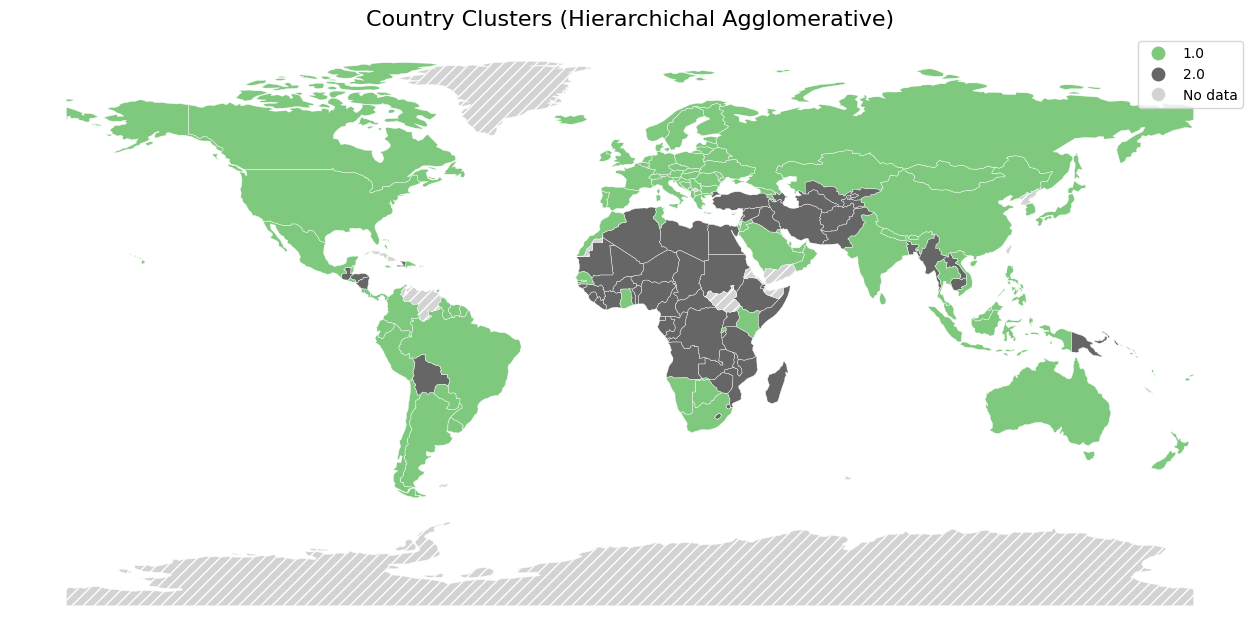

In [43]:
fig, ax = plt.subplots(figsize=(16, 8))

world_clusters.plot(
    column="cluster_agglo",
    categorical=True,
    legend=True,
    ax=ax,
    cmap="Accent",
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    edgecolor="white",
    linewidth=0.3
)

ax.set_title("Country Clusters (Hierarchichal Agglomerative)", fontsize=16)
ax.set_axis_off()
plt.show()

## Countries of Cuba, Venezuela, Sudan, Eritrea, Somaliland, Yemen and North Korea, for which there is no data would most likely fall into the second cluster (and 3rd in K-means/PAM). As for the actual results, we may notice that the majority of countries of the second cluster are located in Africa, except for few countries - mostly in the south.

Second biggest subgroup of cluster 2 is visible in the Middle East and parts of Central Asia. Last, two smallest subgroups are located in Southeast Asia and Central America. Except for that, only singular countries may be pointed out - such as Bolivia, the only cluster 2 country of South America, and Papua New Guinea, only Oceanian country of that grouping. What is interesting to notice that Turkey is also assigned to cluster 2. This is most likely due to their political institutions performance and therefore low WGI indicator values. It is also important to note that all of the European, North American and most of Far East Asian countries belong to cluster 1.

In [44]:
wide[wide["Country Name"]=="Turkiye"]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
170,Turkiye,TUR,0.237856,-0.468106,100.0,-0.199645,-1.032235,-0.459681,-0.244639,0.031828,8.0,77.591,-0.926404,2,2,2


# Group analysis for K-means and PAM clustering

In [45]:
wide[features].describe()

Series Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,86.521196,72.437435,19.984239,0.444675,0.191609,-0.022392,-0.084721,-0.053966,-0.041983,-0.047843,-0.054274
std,23.585344,7.989915,21.265126,0.810218,0.224966,0.971181,0.962735,0.952824,0.937209,0.957007,0.983686
min,10.300000,18.818000,1.400000,0.001167,0.000099,-1.946265,-2.776898,-2.228161,-2.089348,-2.287279,-1.792611
25%,84.400000,67.404750,5.075000,0.018239,0.059255,-0.854022,-0.629996,-0.765052,-0.714083,-0.757770,-0.767299
50%,100.000000,73.417000,13.200000,0.090092,0.119383,0.021517,-0.018716,-0.106993,-0.150161,-0.162027,-0.297659
75%,100.000000,77.506152,30.900000,0.410638,0.232642,0.849697,0.727070,0.566299,0.551190,0.630636,0.565911
max,100.000000,85.708000,189.100000,4.528834,1.480922,1.780675,1.585988,2.144236,2.214378,1.957900,2.402638


In [46]:
cluster_profiles_mean = wide.groupby("cluster_kmeans")[features].mean()
cluster_profiles_mean

Series Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
cluster_kmeans,,,,,,,,,,,
1,99.169697,78.003524,7.678788,0.059762,0.179018,0.916618,0.780538,0.923202,0.910225,0.990588,1.025468
2,94.432927,72.790602,16.723171,0.190255,0.199286,-0.419403,-0.349757,-0.381424,-0.403114,-0.467833,-0.540703
3,45.311111,61.428500,49.972222,1.729859,0.197203,-0.839606,-1.067335,-1.099563,-0.965123,-0.994988,-0.925824


In [47]:
wide[wide["cluster_kmeans"] == 1]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
3,Andorra,AND,0.009380,1.270272,100.0,1.495261,1.585988,1.485483,1.398334,0.014257,2.6,84.016000,1.106789,1,1,1
5,Antigua and Barbuda,ATG,0.043085,0.310728,100.0,-0.160003,0.938082,0.390787,0.289087,0.049602,7.5,77.483000,0.724553,1,1,1
8,Australia,AUS,1.201635,1.764367,100.0,1.528433,0.983716,1.508819,1.894893,0.005504,3.2,83.200000,1.323907,1,1,1
9,Austria,AUT,0.146053,1.258587,100.0,1.464923,0.648710,1.704273,1.283200,0.009303,2.7,81.295122,1.413658,1,1,1
11,"Bahamas, The",BHS,0.020124,1.256449,100.0,0.423950,0.881239,0.134540,-0.146486,0.098562,11.6,74.491000,0.872308,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Switzerland,CHE,0.045186,2.009362,100.0,2.049435,1.159745,1.751188,1.620113,0.004920,3.5,83.604878,1.621347,1,1,1
174,United Arab Emirates,ARE,0.005001,1.155614,100.0,1.299128,0.744183,0.836057,1.034781,0.003111,4.2,80.487000,-1.127491,1,1,1
175,United Kingdom,GBR,0.089360,1.620121,100.0,1.238090,0.533176,1.413798,1.566510,0.020910,3.9,81.011220,1.258541,1,1,1
176,United States,USA,0.453732,1.104145,100.0,1.255496,0.008701,1.369202,1.424440,0.029769,5.5,77.434146,0.860348,1,1,1


In [48]:
wide[wide["cluster_kmeans"] == 2]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
1,Albania,ALB,0.243960,-0.408189,100.0,0.064541,0.106261,-0.165585,0.159354,0.010570,8.3,78.769000,0.141740,2,2,1
2,Algeria,DZA,0.165599,-0.638041,100.0,-0.513499,-0.650652,-0.833260,-1.063573,0.169461,20.0,76.129000,-1.011919,2,2,2
6,Argentina,ARG,0.949152,-0.447222,100.0,-0.283490,-0.098594,-0.482352,-0.697566,0.053596,8.3,75.806000,0.546317,2,2,1
7,Armenia,ARM,0.149108,0.027907,100.0,-0.314792,-0.740756,-0.169516,-0.019079,0.039488,9.3,74.765854,0.090326,2,2,1
10,Azerbaijan,AZE,0.206266,-1.040907,100.0,-0.041207,-0.922807,-0.625552,-0.103344,0.046683,14.1,74.125000,-1.441627,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Uzbekistan,UZB,0.115301,-0.757770,100.0,-0.329937,-0.201336,-0.852307,-0.550315,0.090770,13.1,72.147000,-1.330924,2,2,2
179,Vanuatu,VUT,0.063888,-0.028580,71.6,-0.538525,0.961862,0.322184,-0.090816,0.397198,14.4,71.302000,0.585711,2,2,1
180,Viet Nam,VNM,0.067746,-0.287254,100.0,0.174635,-0.046132,-0.158469,-0.429956,0.083527,14.3,74.502000,-1.286407,2,2,1
181,West Bank and Gaza,PSE,0.008308,-0.702708,100.0,-0.902029,-1.701955,-0.555172,-0.036869,0.059103,12.3,76.662000,-1.035614,2,2,2


In [49]:
wide[wide["cluster_kmeans"] == 3]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2
4,Angola,AGO,0.151115,-0.612376,48.5,-1.026034,-0.630109,-1.022036,-0.606699,0.966423,39.6,64.246,-0.807578,3,3,2
18,Benin,BEN,0.257709,-0.089857,56.5,-0.170590,-0.343203,-0.596109,-0.348365,2.433684,47.7,60.475,-0.335694,3,3,2
26,Burkina Faso,BFA,0.351298,-0.111639,19.5,-0.853149,-1.815369,-0.611934,-0.468306,1.314541,46.1,60.700,-0.684045,3,3,2
27,Burundi,BDI,0.097102,-1.518181,10.3,-1.263606,-1.192446,-1.276546,-0.947486,1.907926,32.4,62.882,-1.396354,3,3,2
30,Cameroon,CMR,0.224371,-1.129714,71.0,-0.881508,-1.379629,-1.038936,-0.898889,1.225686,42.5,62.443,-1.147254,3,3,2
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2
33,Chad,TCD,0.287180,-1.488538,11.7,-1.423674,-1.470405,-1.373562,-1.149357,4.528834,60.3,54.528,-1.471253,3,3,2
38,"Congo, Dem. Rep.",COD,0.141624,-1.544922,21.5,-1.746675,-1.984490,-1.671785,-1.476069,2.643696,45.8,60.979,-1.191442,3,3,2
39,"Congo, Rep.",COG,0.091133,-1.359779,50.6,-1.370098,0.038994,-1.090346,-1.261431,0.974436,28.5,65.000,-1.199195,3,3,2



### As for descriptive statistics analysis for the K-means clustering: conclusions about cluster 1 are the same as for cluster 1 of hierarchichal algorithm, however on average, they outperform the 'dataset global' even more. That is most likely due to the higher amount of clusters, as countries which were weighing the averages down in the first cluster of previous algorithm, will now most likely be in the second cluster. Most of countries from the first cluster, will be most likely considered 'developed' in economical sense.

### Second cluster, in comparison to the 'dataset global' average, is on par for the health related variables (and is even twice as low in the maternal risk of death percentage metric). For the political institutions performance metrics however, those countries are doing much worse than the 'dataset global' average. This could imply that those countries not necesarilly require aid in the healthcare dimension, but rather political one. However, when compared to countries of cluster 3, political and institutional performance of those countries is not as grim on average.

### Countries of the third cluster are doing much worse than the 'dataset global' average in every single metric - wheter it would be health, development or political institutions performance related. This is the group of countries which has the most countries in need.

### Analysis of descriptive statistics for PAM clustering groups yields the same conclusions - changes in averages are unsubstantial between models and general patterns in which the groups fall into for each of the variables is identical.

### Descriptive statistics for PAM clusters

In [50]:
wide[features].describe()

Series Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,86.521196,72.437435,19.984239,0.444675,0.191609,-0.022392,-0.084721,-0.053966,-0.041983,-0.047843,-0.054274
std,23.585344,7.989915,21.265126,0.810218,0.224966,0.971181,0.962735,0.952824,0.937209,0.957007,0.983686
min,10.300000,18.818000,1.400000,0.001167,0.000099,-1.946265,-2.776898,-2.228161,-2.089348,-2.287279,-1.792611
25%,84.400000,67.404750,5.075000,0.018239,0.059255,-0.854022,-0.629996,-0.765052,-0.714083,-0.757770,-0.767299
50%,100.000000,73.417000,13.200000,0.090092,0.119383,0.021517,-0.018716,-0.106993,-0.150161,-0.162027,-0.297659
75%,100.000000,77.506152,30.900000,0.410638,0.232642,0.849697,0.727070,0.566299,0.551190,0.630636,0.565911
max,100.000000,85.708000,189.100000,4.528834,1.480922,1.780675,1.585988,2.144236,2.214378,1.957900,2.402638


In [51]:
cluster_profiles_mean = wide.groupby("cluster_pam")[features].mean()
cluster_profiles_mean

Series Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
cluster_pam,,,,,,,,,,,
1,99.219048,78.296333,7.185714,0.057482,0.179106,0.933705,0.800270,0.954201,0.935553,1.018730,1.060437
2,97.509333,73.491747,14.592000,0.148454,0.202620,-0.347791,-0.267112,-0.309810,-0.321902,-0.401596,-0.491801
3,51.215217,62.694304,46.304348,1.457929,0.190778,-0.801287,-0.999397,-1.017579,-0.924393,-0.931813,-0.867584


In [52]:
wide[wide["cluster_pam"] == 1]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
3,Andorra,AND,0.009380,1.270272,100.0,1.495261,1.585988,1.485483,1.398334,0.014257,2.6,84.016000,1.106789,1,1,1
5,Antigua and Barbuda,ATG,0.043085,0.310728,100.0,-0.160003,0.938082,0.390787,0.289087,0.049602,7.5,77.483000,0.724553,1,1,1
8,Australia,AUS,1.201635,1.764367,100.0,1.528433,0.983716,1.508819,1.894893,0.005504,3.2,83.200000,1.323907,1,1,1
9,Austria,AUT,0.146053,1.258587,100.0,1.464923,0.648710,1.704273,1.283200,0.009303,2.7,81.295122,1.413658,1,1,1
11,"Bahamas, The",BHS,0.020124,1.256449,100.0,0.423950,0.881239,0.134540,-0.146486,0.098562,11.6,74.491000,0.872308,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Switzerland,CHE,0.045186,2.009362,100.0,2.049435,1.159745,1.751188,1.620113,0.004920,3.5,83.604878,1.621347,1,1,1
174,United Arab Emirates,ARE,0.005001,1.155614,100.0,1.299128,0.744183,0.836057,1.034781,0.003111,4.2,80.487000,-1.127491,1,1,1
175,United Kingdom,GBR,0.089360,1.620121,100.0,1.238090,0.533176,1.413798,1.566510,0.020910,3.9,81.011220,1.258541,1,1,1
176,United States,USA,0.453732,1.104145,100.0,1.255496,0.008701,1.369202,1.424440,0.029769,5.5,77.434146,0.860348,1,1,1


In [53]:
wide[wide["cluster_pam"] == 2]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
1,Albania,ALB,0.243960,-0.408189,100.0,0.064541,0.106261,-0.165585,0.159354,0.010570,8.3,78.769000,0.141740,2,2,1
2,Algeria,DZA,0.165599,-0.638041,100.0,-0.513499,-0.650652,-0.833260,-1.063573,0.169461,20.0,76.129000,-1.011919,2,2,2
6,Argentina,ARG,0.949152,-0.447222,100.0,-0.283490,-0.098594,-0.482352,-0.697566,0.053596,8.3,75.806000,0.546317,2,2,1
7,Armenia,ARM,0.149108,0.027907,100.0,-0.314792,-0.740756,-0.169516,-0.019079,0.039488,9.3,74.765854,0.090326,2,2,1
10,Azerbaijan,AZE,0.206266,-1.040907,100.0,-0.041207,-0.922807,-0.625552,-0.103344,0.046683,14.1,74.125000,-1.441627,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Ukraine,UKR,0.802070,-0.634004,100.0,-0.497119,-1.949325,-0.917948,-0.331597,0.011485,8.0,72.658000,-0.023307,2,2,1
178,Uzbekistan,UZB,0.115301,-0.757770,100.0,-0.329937,-0.201336,-0.852307,-0.550315,0.090770,13.1,72.147000,-1.330924,2,2,2
179,Vanuatu,VUT,0.063888,-0.028580,71.6,-0.538525,0.961862,0.322184,-0.090816,0.397198,14.4,71.302000,0.585711,2,2,1
180,Viet Nam,VNM,0.067746,-0.287254,100.0,0.174635,-0.046132,-0.158469,-0.429956,0.083527,14.3,74.502000,-1.286407,2,2,1


In [54]:
wide[wide["cluster_pam"] == 3]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2
4,Angola,AGO,0.151115,-0.612376,48.5,-1.026034,-0.630109,-1.022036,-0.606699,0.966423,39.6,64.246,-0.807578,3,3,2
18,Benin,BEN,0.257709,-0.089857,56.5,-0.170590,-0.343203,-0.596109,-0.348365,2.433684,47.7,60.475,-0.335694,3,3,2
26,Burkina Faso,BFA,0.351298,-0.111639,19.5,-0.853149,-1.815369,-0.611934,-0.468306,1.314541,46.1,60.700,-0.684045,3,3,2
27,Burundi,BDI,0.097102,-1.518181,10.3,-1.263606,-1.192446,-1.276546,-0.947486,1.907926,32.4,62.882,-1.396354,3,3,2
30,Cameroon,CMR,0.224371,-1.129714,71.0,-0.881508,-1.379629,-1.038936,-0.898889,1.225686,42.5,62.443,-1.147254,3,3,2
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2
33,Chad,TCD,0.287180,-1.488538,11.7,-1.423674,-1.470405,-1.373562,-1.149357,4.528834,60.3,54.528,-1.471253,3,3,2
37,Comoros,COM,0.077920,-1.244992,89.9,-1.683057,-0.226411,-1.314605,-1.200538,0.698912,36.8,66.481,-0.851324,2,3,2
38,"Congo, Dem. Rep.",COD,0.141624,-1.544922,21.5,-1.746675,-1.984490,-1.671785,-1.476069,2.643696,45.8,60.979,-1.191442,3,3,2


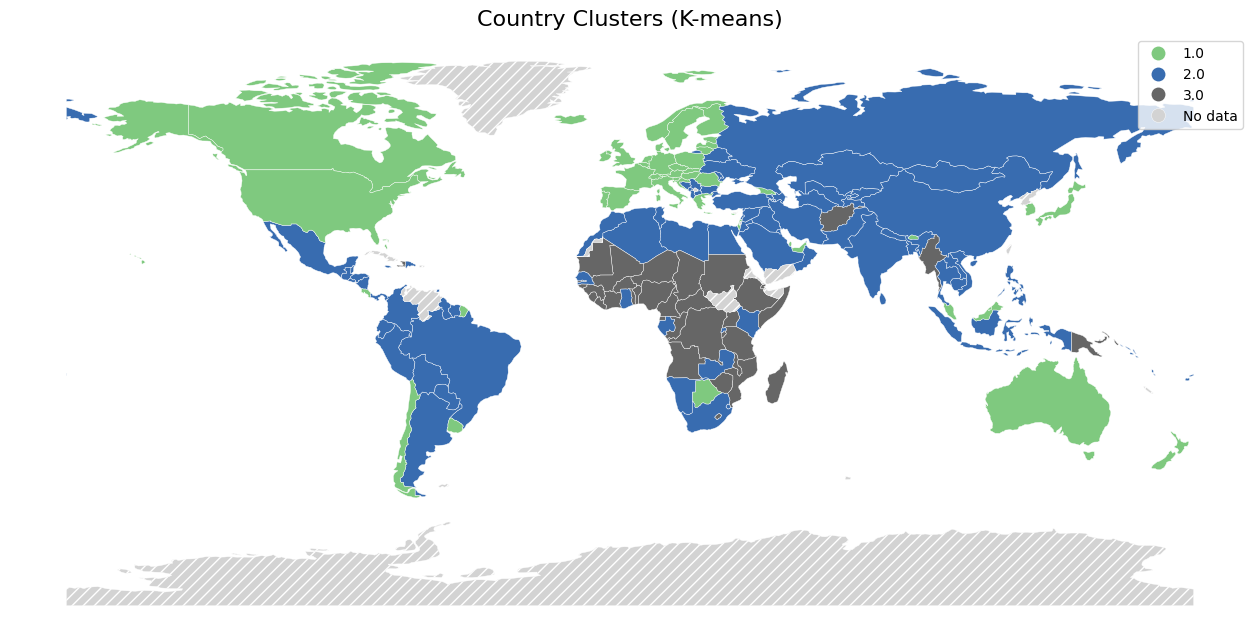

In [55]:
fig, ax = plt.subplots(figsize=(16, 8))

world_clusters.plot(
    column="cluster_kmeans",
    categorical=True,
    legend=True,
    ax=ax,
    cmap="Accent",
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    edgecolor="white",
    linewidth=0.3
)

ax.set_title("Country Clusters (K-means)", fontsize=16)
ax.set_axis_off()
plt.show()

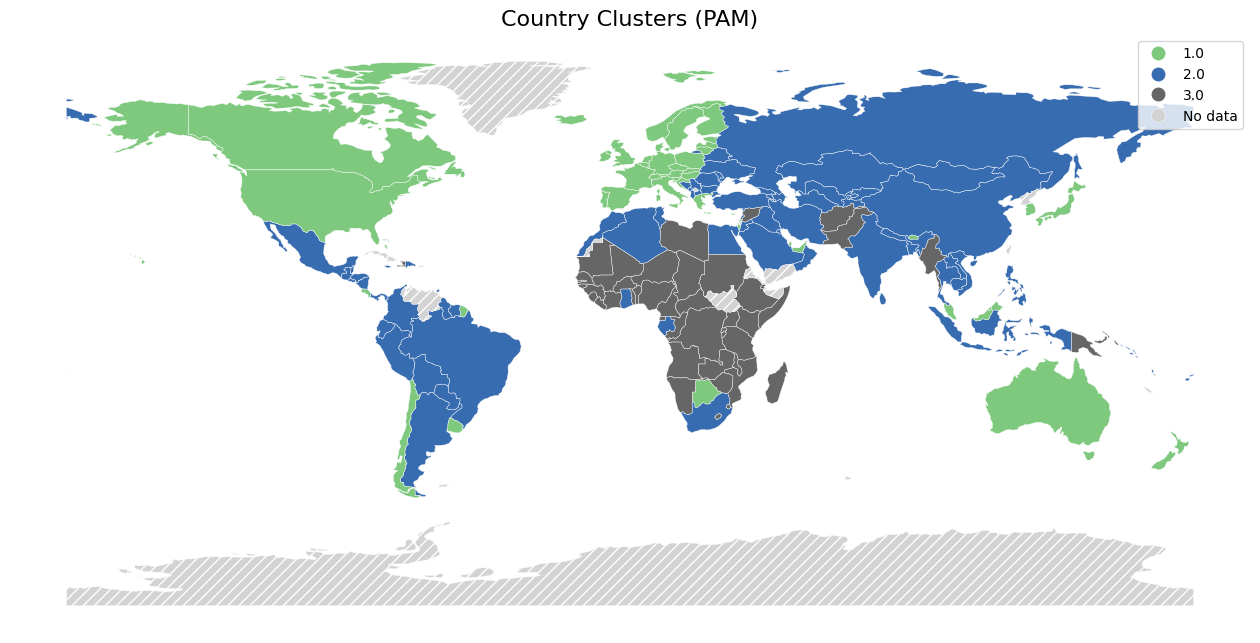

In [56]:
fig, ax = plt.subplots(figsize=(16, 8))

world_clusters.plot(
    column="cluster_pam",
    categorical=True,
    legend=True,
    ax=ax,
    cmap="Accent",
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    edgecolor="white",
    linewidth=0.3
)

ax.set_title("Country Clusters (PAM)", fontsize=16)
ax.set_axis_off()
plt.show()

## With regard to group structures, the PAM and K-means clustering results are very similar, which may be also observed by comparing the maps. Although both the average silhouette width and the Calinski–Harabasz index are lower for PAM, the resulting cluster structure appears more coherent from an interpretative perspective. In particular, assigning countries such as Georgia to the same cluster as predominantly highly developed countries seems questionable, given its persistent institutional and political challenges.

### A similar issue arises in the case of Syria. As a country affected by prolonged armed conflict and political instability, it is difficult to justify placing it in the same cluster as several East and South European, East Asian, or South American countries. For these reasons, despite slightly weaker performance on statistical validation metrics, I consider the PAM clustering as more appropriate for interpretation. Consequently, only the PAM results are discussed further.

### As expected, first cluster is dominated by Europe (excluding Eastern and partly Southern parts), along with USA, Canada, Australia, New Zealand, Japan and South Korea. Interestingly, this group also includes Costa Rica, Chile, Uruguay, Malaysia and - perhaps most unexpectedly -  Botswana and Bhutan.

### Second cluster consists primarly of countries from South and Central America, Eastern and Southern Europe, the Middle East, Eastern and Central Asia, and North Africa.

### Third cluster is composed mainly of African countries, as well as Syria, Iran, Pakistan, Myanmar, Papua New Guinea.

### While the identified cluster structure provides a useful high-level classification, it does not directly indicate the specific areas in which aid should be allocated. To address this issue, a more detailed examination of the underlying indicators is required. In general, all countries appearing in the top-five rankings presented below may be considered eligible for aid; however, particular attention is given to those countries that appear most frequently across these rankings.

In [57]:
pam_struggling = wide[wide["cluster_pam"].isin([2, 3])]

In [58]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("life_expectancy", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
121,Nigeria,NGA,0.165233,-1.129682,60.5,-1.041517,-1.778901,-0.913985,-1.155945,4.213807,61.6,54.079,-0.598563,3,3,2
33,Chad,TCD,0.287180,-1.488538,11.7,-1.423674,-1.470405,-1.373562,-1.149357,4.528834,60.3,54.528,-1.471253,3,3,2
93,Lesotho,LSO,0.118717,-0.368641,50.0,-0.887993,-0.292737,-0.473294,-0.615312,1.294376,57.6,56.812,0.050188,3,3,2


In [59]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("infant_mortality_per_1000", ascending=False).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
120,Niger,NER,0.699274,-0.584792,19.5,-0.627598,-1.464392,-0.498117,-0.720804,2.214478,68.3,60.398,-0.375445,3,3,2
67,Guinea,GIN,0.394865,-0.971790,47.7,-0.914216,-0.838682,-1.097719,-1.050105,2.186564,63.1,60.432,-1.083162,3,3,2
121,Nigeria,NGA,0.165233,-1.129682,60.5,-1.041517,-1.778901,-0.913985,-1.155945,4.213807,61.6,54.079,-0.598563,3,3,2


In [60]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("maternal_death_risk_pct", ascending=False).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
33,Chad,TCD,0.287180,-1.488538,11.7,-1.423674,-1.470405,-1.373562,-1.149357,4.528834,60.3,54.528,-1.471253,3,3,2
121,Nigeria,NGA,0.165233,-1.129682,60.5,-1.041517,-1.778901,-0.913985,-1.155945,4.213807,61.6,54.079,-0.598563,3,3,2
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2


## With regard to health-related aid, the Central African Republic appears to have been in the most severe need in 2022, as reflected by extreme values across multiple health indicators. This situation was largely shaped by prolonged civil conflict and widespread poverty. In 2026 the situation has gotten better, however after such devastating conflict recovery will still be extremely time consuming. For this reason, the country should be considered a priority recipient of humanitarian assistance and healthcare-related investments. Other countries that consistently appear among the worst performers in the health dimension include Nigeria, Chad, and Somalia, which are repeatedly present in the top-five rankings. These countries should therefore also be regarded as requiring urgent humanitarian support.

In [61]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("electricity_access", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
27,Burundi,BDI,0.097102,-1.518181,10.3,-1.263606,-1.192446,-1.276546,-0.947486,1.907926,32.4,62.882,-1.396354,3,3,2
33,Chad,TCD,0.287180,-1.488538,11.7,-1.423674,-1.470405,-1.373562,-1.149357,4.528834,60.3,54.528,-1.471253,3,3,2
99,Malawi,MWI,0.194470,-0.608852,14.0,-0.853226,-0.157983,-0.221973,-0.739736,0.956502,30.5,66.037,0.062155,3,3,2
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2
128,Papua New Guinea,PNG,0.032343,-0.696280,19.0,-0.810511,-0.659367,-0.615988,-0.682209,0.574722,33.0,65.274,-0.020892,3,3,2


## As for energy infrastructure and its development, Burundi tops the chart as the most elligible for aid in that area. Chad appears once again among the weakest performers, although this time with respect to a different dimension of development, highlighting the multidimensional nature of its challenges.

In [62]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("wgi_control_of_corruption", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
161,Syrian Arab Republic,SYR,0.195840,-1.776185,89.0,-1.753014,-2.776898,-2.069141,-1.823900,0.053009,19.5,72.790,-1.895417,2,3,2
52,Equatorial Guinea,GNQ,0.029387,-1.601969,67.0,-1.297055,-0.236289,-1.408268,-1.493266,0.768854,50.9,63.355,-1.704316,3,3,2
38,"Congo, Dem. Rep.",COD,0.141624,-1.544922,21.5,-1.746675,-1.984490,-1.671785,-1.476069,2.643696,45.8,60.979,-1.191442,3,3,2
95,Libya,LBY,0.238102,-1.526298,70.0,-1.755772,-2.193702,-1.801423,-2.089348,0.124600,8.4,74.462,-1.381293,2,3,2


In [63]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("wgi_government_effectiveness", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
70,Haiti,HTI,0.087364,-1.459188,49.3,-2.228161,-1.419199,-1.377952,-1.314384,0.869533,41.5,63.948,-1.192722,3,3,2
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2
95,Libya,LBY,0.238102,-1.526298,70.0,-1.755772,-2.193702,-1.801423,-2.089348,0.124600,8.4,74.462,-1.381293,2,3,2
161,Syrian Arab Republic,SYR,0.195840,-1.776185,89.0,-1.753014,-2.776898,-2.069141,-1.823900,0.053009,19.5,72.790,-1.895417,2,3,2


In [64]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("wgi_political_stability_and_absence_of_terrorism", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
161,Syrian Arab Republic,SYR,0.195840,-1.776185,89.0,-1.753014,-2.776898,-2.069141,-1.823900,0.053009,19.5,72.790,-1.895417,2,3,2
102,Mali,MLI,0.361510,-0.844120,53.0,-1.148953,-2.560744,-0.982343,-0.634122,2.150004,59.0,60.035,-0.920923,3,3,2
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2


In [65]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("wgi_rule_of_law", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
161,Syrian Arab Republic,SYR,0.195840,-1.776185,89.0,-1.753014,-2.776898,-2.069141,-1.823900,0.053009,19.5,72.790,-1.895417,2,3,2
95,Libya,LBY,0.238102,-1.526298,70.0,-1.755772,-2.193702,-1.801423,-2.089348,0.124600,8.4,74.462,-1.381293,2,3,2
32,Central African Republic,CAF,0.353077,-1.246147,15.7,-1.710303,-2.205052,-1.699912,-1.474184,4.156802,189.1,18.818,-1.214004,3,3,2
38,"Congo, Dem. Rep.",COD,0.141624,-1.544922,21.5,-1.746675,-1.984490,-1.671785,-1.476069,2.643696,45.8,60.979,-1.191442,3,3,2


In [66]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("wgi_regulatory_quality", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
95,Libya,LBY,0.238102,-1.526298,70.0,-1.755772,-2.193702,-1.801423,-2.089348,0.124600,8.4,74.462,-1.381293,2,3,2
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2
161,Syrian Arab Republic,SYR,0.195840,-1.776185,89.0,-1.753014,-2.776898,-2.069141,-1.823900,0.053009,19.5,72.790,-1.895417,2,3,2
157,Sudan,SDN,0.425143,-1.413729,63.2,-1.686378,-2.076920,-1.260093,-1.581311,1.124292,40.3,65.695,-1.494462,3,3,2
52,Equatorial Guinea,GNQ,0.029387,-1.601969,67.0,-1.297055,-0.236289,-1.408268,-1.493266,0.768854,50.9,63.355,-1.704316,3,3,2


In [67]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 3].sort_values("wgi_voice_and_accountabillity", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
161,Syrian Arab Republic,SYR,0.195840,-1.776185,89.0,-1.753014,-2.776898,-2.069141,-1.823900,0.053009,19.5,72.790,-1.895417,2,3,2
114,Myanmar,MMR,0.204439,-1.151526,73.6,-1.685024,-2.195714,-1.528093,-1.235084,0.375453,35.2,66.506,-1.811238,3,3,2
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2
52,Equatorial Guinea,GNQ,0.029387,-1.601969,67.0,-1.297055,-0.236289,-1.408268,-1.493266,0.768854,50.9,63.355,-1.704316,3,3,2
150,"Somalia, Fed. Rep.",SOM,0.061791,-1.792611,48.9,-2.027404,-2.429696,-2.287279,-1.900156,3.753206,89.9,53.931,-1.668942,3,3,2


## As for the policies and political institutions performance, Syria, Somalia and Libya consistently occupy the lowest positions across governance related indicators. As such, they represent the most urgent cases for institutional and governance-focused assistance.

## Below, the institutions quality of worst performing cluster 2 countries will also be analyzed:

In [68]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 2].sort_values("wgi_control_of_corruption", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
171,Turkmenistan,TKM,0.222733,-1.437132,100.0,-1.158998,-0.110258,-1.492312,-2.067061,0.012465,32.0,69.91300,-1.946265,2,2,2
162,Tajikistan,TJK,0.082379,-1.434276,100.0,-0.757131,-0.740999,-1.255565,-1.197977,0.048616,23.1,71.56200,-1.673658,2,2,2
119,Nicaragua,NIC,0.223307,-1.287625,86.5,-1.036879,-0.358512,-1.310912,-0.914734,0.139080,10.7,74.46300,-1.350020,2,2,2
29,Cambodia,KHM,0.239519,-1.241612,92.3,-0.351414,-0.098023,-0.865881,-0.709801,0.401231,21.1,70.52800,-1.309937,2,2,2
89,Kyrgyz Republic,KGZ,0.184422,-1.230403,99.7,-0.890511,-0.471610,-1.147709,-0.632588,0.119961,15.1,72.04878,-0.730021,2,2,2


In [69]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 2].sort_values("wgi_government_effectiveness", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
92,Lebanon,LBN,0.023759,-1.127302,100.0,-1.459290,-1.422575,-1.103063,-1.132511,0.030969,15.1,78.003,-0.630630,2,2,2
77,Iraq,IRQ,0.112751,-1.213353,100.0,-1.302760,-2.409309,-1.749940,-1.180485,0.194817,21.5,72.037,-0.948579,2,2,2
171,Turkmenistan,TKM,0.222733,-1.437132,100.0,-1.158998,-0.110258,-1.492312,-2.067061,0.012465,32.0,69.913,-1.946265,2,2,2
21,Bosnia and Herzegovina,BIH,0.117636,-0.684316,100.0,-1.064961,-0.483194,-0.306983,-0.157615,0.012946,5.5,76.777,-0.324730,2,2,1
119,Nicaragua,NIC,0.223307,-1.287625,86.5,-1.036879,-0.358512,-1.310912,-0.914734,0.139080,10.7,74.463,-1.350020,2,2,2


In [70]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 2].sort_values("wgi_political_stability_and_absence_of_terrorism", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
77,Iraq,IRQ,0.112751,-1.213353,100.0,-1.302760,-2.409309,-1.749940,-1.180485,0.194817,21.5,72.037,-0.948579,2,2,2
173,Ukraine,UKR,0.802070,-0.634004,100.0,-0.497119,-1.949325,-0.917948,-0.331597,0.011485,8.0,72.658,-0.023307,2,2,1
181,West Bank and Gaza,PSE,0.008308,-0.702708,100.0,-0.902029,-1.701955,-0.555172,-0.036869,0.059103,12.3,76.662,-1.035614,2,2,2
76,"Iran, Islamic Rep.",IRN,0.175360,-1.126616,100.0,-0.882912,-1.625612,-1.017585,-1.592711,0.032861,11.0,76.799,-1.460602,2,2,2
92,Lebanon,LBN,0.023759,-1.127302,100.0,-1.459290,-1.422575,-1.103063,-1.132511,0.030969,15.1,78.003,-0.630630,2,2,2


In [71]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 2].sort_values("wgi_rule_of_law", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
77,Iraq,IRQ,0.112751,-1.213353,100.0,-1.302760,-2.409309,-1.749940,-1.180485,0.194817,21.5,72.037,-0.948579,2,2,2
171,Turkmenistan,TKM,0.222733,-1.437132,100.0,-1.158998,-0.110258,-1.492312,-2.067061,0.012465,32.0,69.913,-1.946265,2,2,2
119,Nicaragua,NIC,0.223307,-1.287625,86.5,-1.036879,-0.358512,-1.310912,-0.914734,0.139080,10.7,74.463,-1.350020,2,2,2
20,Bolivia,BOL,0.460586,-0.889700,99.9,-0.564738,-0.191909,-1.301404,-1.210536,0.421206,20.7,67.434,-0.197486,2,2,2
162,Tajikistan,TJK,0.082379,-1.434276,100.0,-0.757131,-0.740999,-1.255565,-1.197977,0.048616,23.1,71.562,-1.673658,2,2,2


In [72]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 2].sort_values("wgi_regulatory_quality", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
171,Turkmenistan,TKM,0.222733,-1.437132,100.0,-1.158998,-0.110258,-1.492312,-2.067061,0.012465,32.0,69.913000,-1.946265,2,2,2
76,"Iran, Islamic Rep.",IRN,0.175360,-1.126616,100.0,-0.882912,-1.625612,-1.017585,-1.592711,0.032861,11.0,76.799000,-1.460602,2,2,2
15,Belarus,BLR,0.607494,-0.579731,100.0,-0.851723,-0.802097,-1.221000,-1.331214,0.001167,2.0,74.103366,-1.627728,2,2,1
20,Bolivia,BOL,0.460586,-0.889700,99.9,-0.564738,-0.191909,-1.301404,-1.210536,0.421206,20.7,67.434000,-0.197486,2,2,2
162,Tajikistan,TJK,0.082379,-1.434276,100.0,-0.757131,-0.740999,-1.255565,-1.197977,0.048616,23.1,71.562000,-1.673658,2,2,2


In [73]:
pam_struggling.loc[pam_struggling["cluster_pam"] == 2].sort_values("wgi_voice_and_accountabillity", ascending=True).head(5)

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo
171,Turkmenistan,TKM,0.222733,-1.437132,100.0,-1.158998,-0.110258,-1.492312,-2.067061,0.012465,32.0,69.913000,-1.946265,2,2,2
162,Tajikistan,TJK,0.082379,-1.434276,100.0,-0.757131,-0.740999,-1.255565,-1.197977,0.048616,23.1,71.562000,-1.673658,2,2,2
90,Lao PDR,LAO,0.161926,-0.965779,100.0,-0.597130,0.789451,-0.804428,-0.987143,0.306543,36.4,68.715000,-1.658109,2,2,2
15,Belarus,BLR,0.607494,-0.579731,100.0,-0.851723,-0.802097,-1.221000,-1.331214,0.001167,2.0,74.103366,-1.627728,2,2,1
35,China,CHN,0.076875,0.016064,100.0,0.494213,-0.451277,-0.042176,-0.418418,0.015599,4.8,78.202000,-1.601371,2,2,1


## Notably, the weakest performing countries within cluster 2 are often close to - or even comparable with - the lowest ranked countries in cluster 3 in terms of World Governance Indicators. Turkmenistan, Tajikistan, Iraq and Iran appear in nearly every relevant table, indicating a huge need for institutional support. Belarus and Nicaragua would also qualify, as those countries are listed in two and three tables out of six respectively.

# Chapter I - Summary



 The objective of this part of the project was to identify both the countries most in need of aid and the types of assistance that would be most appropriate. This was achieved through the application of machine learning techniques in the field of data clustering. The analysis began with the necessary data transformation, followed by an evaluation of clustering performance in order to determine an appropriate number of clusters for the K-means, Partitioning Around Medoids (PAM), and hierarchical agglomerative clustering algorithms. The final stage involved a comparative assessment of the selected models, an examination of cluster characteristics, and a visualization of the resulting group structures on a world map. Further conclusion and discussion of the results will be presented at the end of the project.

# Part II - Dimension reduction and Clustering revisited

## Chapter I - Insights of the dataset

### Sevreal out of the 11 features in the dataset are quite similar. For instance, Life_expectancy, infant_mortality_per_1000 and maternal_death_risk_pct could be classified as health related variables. Similarly,  WGI indicators, such as wgi_control_of_corruption, capture different aspects of institutional performance. As a result, it is possible that a smaller number of variables - could adequately represent the information contained within each thematic dimension.

It could probably be expected, that for example, as there is an increase in a country's life expectancy, decrease in maternal and infant mortality rates will be also observed, suggesting a strong correlation among these measures. This raises the possibility that much of the variation within given dimension could by summarized by fewer underlying factors.

Therefore, the second part of the project will be focused on Prinicpal Component Analysis (PCA) as a dimension reduction approach. The resulting compotents then will be used as inputs for clustering in order to determine how dimensionality reducing affects the structure and intepretation of clusters. Clustering analysis however will not be as extensive as in Part I, as the primary focus is set on the topic of dimension reduction.

In [74]:
corr = data_scaled.select_dtypes('number').corr()

<Axes: >

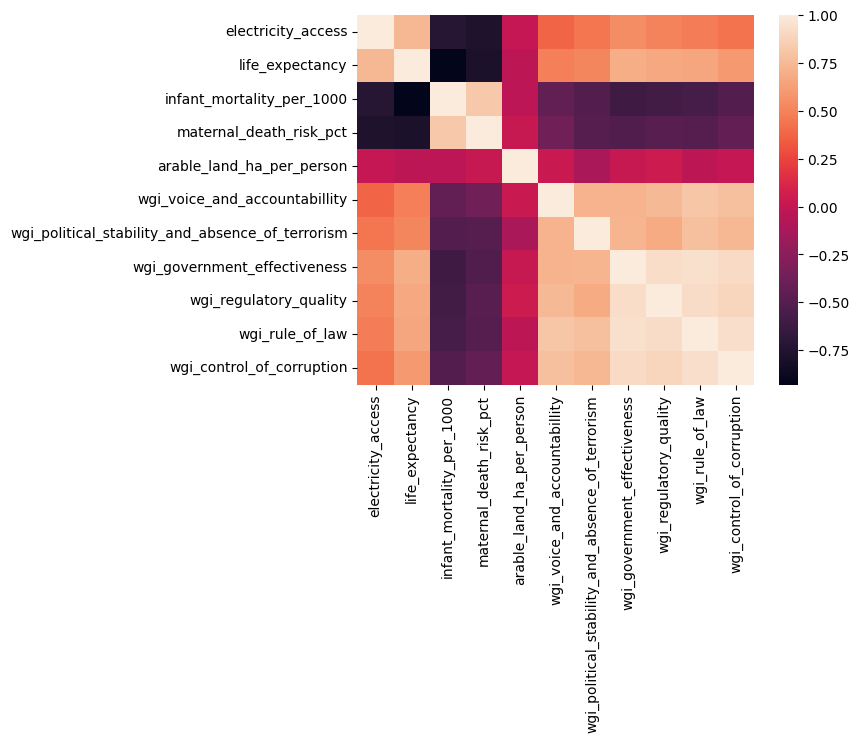

In [75]:
sns.heatmap(corr)

## Correlation heatmap seems to confirm the initial assumptions. Life expectancy is highly, negatively correlated with infant and maternal mortality rates. Same relationship could be said about eletricity access, which is reasnoable, as it is hard to maintain good healthcare without specalized devices which do require electricity. WGI indicators are also highly and positively correlated with each other.

# Chapter II - PCA

In [76]:
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

 ### Principal Component Analysis (PCA) is a dimensionality reduction method that replaces a potentially large set of correlated variables with a smaller number of orthogonal components, referred to as principal components.
Components are derived as eigenvectors of correlation (or covariance, if the data was not standardized) determining the directions of maximum variance in the data, while eigenvalues indicate the variance explained by each component.

PCA therefore works by projecting observations onto these new orthogonal axes and selecting the leading components, allowing dimensionality reduction while preserving most of the original information. Therefore, similar to initial clustering analysis, it is important to choose a suitable amount of principal components to keep in the model.

#### Higher the eigenvalue of a principal component, higher the variance explained by the principal component, therefore the more important it is.

In [77]:
eigenvalues = pca.explained_variance_
pov = pca.explained_variance_ratio_
cp = np.cumsum(pov)

for i in range(len(eigenvalues)):
    print(f"PC{i+1}: " f"eigenvalue = {eigenvalues[i]:.3f} | " f"proportion of variance = {pov[i]:.3f} | " f"cumulative proportion = {cp[i]:.3f}")

PC1: eigenvalue = 6.974 | proportion of variance = 0.631 | cumulative proportion = 0.631
PC2: eigenvalue = 1.598 | proportion of variance = 0.145 | cumulative proportion = 0.775
PC3: eigenvalue = 1.032 | proportion of variance = 0.093 | cumulative proportion = 0.868
PC4: eigenvalue = 0.437 | proportion of variance = 0.040 | cumulative proportion = 0.908
PC5: eigenvalue = 0.317 | proportion of variance = 0.029 | cumulative proportion = 0.937
PC6: eigenvalue = 0.265 | proportion of variance = 0.024 | cumulative proportion = 0.961
PC7: eigenvalue = 0.182 | proportion of variance = 0.016 | cumulative proportion = 0.977
PC8: eigenvalue = 0.100 | proportion of variance = 0.009 | cumulative proportion = 0.986
PC9: eigenvalue = 0.059 | proportion of variance = 0.005 | cumulative proportion = 0.991
PC10: eigenvalue = 0.055 | proportion of variance = 0.005 | cumulative proportion = 0.996
PC11: eigenvalue = 0.040 | proportion of variance = 0.004 | cumulative proportion = 1.000


## As expected, first principal component contains the most information. If we were to apply Kaiser's rule, therefore keep only principal components that have eigenvalues higher than one, only PC1, PC2 and PC3 would've been chosen. There is no 'correct' way to choose the amount of principal components however, therefore this information should be only taken as a potential hint. By selecting only first three variables, 86,8% of the variance would be explained - which is quite high, but it could be even better.

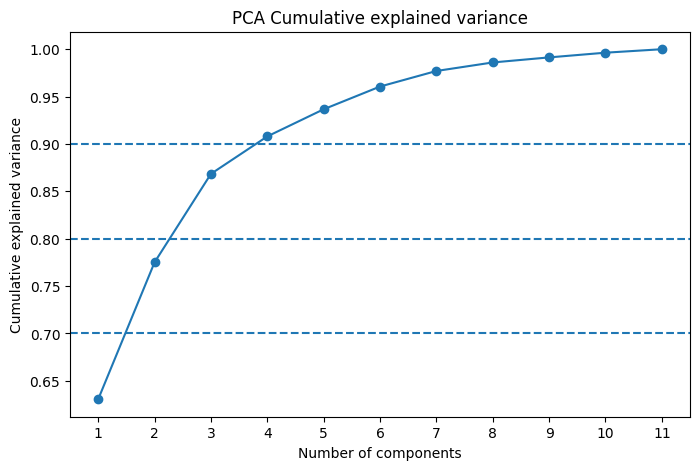

In [78]:
plt.figure(figsize=(8, 5))
plt.plot(
    np.cumsum(pca.explained_variance_ratio_),
    marker="o"
)
plt.axhline(0.7, linestyle="--")
plt.axhline(0.8, linestyle="--")
plt.axhline(0.9, linestyle="--")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Cumulative explained variance")
plt.xticks(np.arange(len(pca.explained_variance_ratio_)), np.arange(1, len(pca.explained_variance_ratio_)+1))
plt.show()

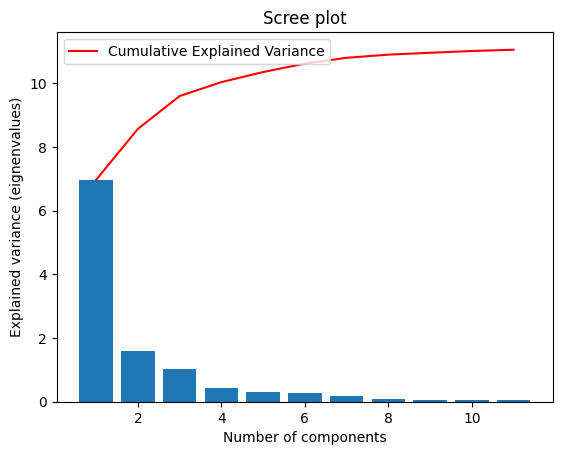

In [79]:
# Code taken from: https://www.jcchouinard.com/pca-scree-plot/

plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

## It is also advised to calculate loadings, in order to see the correlation between original variables and a given principal component. Sign determines the direction of the relationship and magnitute (value) - the importance.

In [80]:
loadings_table = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
loadings_table

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
electricity_access,0.268329,-0.420120,-0.004081,0.158116,0.735454,0.287324,0.298524,0.052506,-0.057999,-0.047201,0.074625
life_expectancy,0.320722,-0.332601,-0.011731,-0.276775,-0.327330,0.050994,0.276581,0.106461,0.035270,0.704952,-0.118300
infant_mortality_per_1000,-0.301963,0.401059,-0.039239,0.079355,0.474082,0.023867,-0.259945,-0.006055,0.048964,0.660743,-0.090680
maternal_death_risk_pct,-0.276798,0.450726,0.028933,-0.232060,0.016724,0.146973,0.797875,0.039624,-0.012096,-0.069590,0.022267
arable_land_ha_per_person,-0.003742,-0.009501,0.980640,0.139608,0.002039,-0.111195,0.033421,0.024415,0.009209,0.063857,0.022499
wgi_voice_and_accountabillity,0.296784,0.304984,0.036063,0.404894,-0.255022,0.742371,-0.077321,-0.025968,0.119698,0.003020,-0.128543
wgi_political_stability_and_absence_of_terrorism,0.303102,0.186122,-0.162196,0.651817,-0.046483,-0.533390,0.310786,-0.117614,-0.086078,0.106834,-0.080033
wgi_government_effectiveness,0.351303,0.176105,0.040581,-0.282267,0.205901,-0.181704,-0.021052,-0.058368,0.651912,-0.174105,-0.479258
wgi_regulatory_quality,0.343149,0.203785,0.077517,-0.327193,0.094153,0.028490,-0.073492,-0.681823,-0.496396,0.005193,-0.035512
wgi_rule_of_law,0.351289,0.252270,-0.012470,-0.125002,0.033543,-0.071218,-0.059955,0.062784,0.292948,0.069703,0.832324


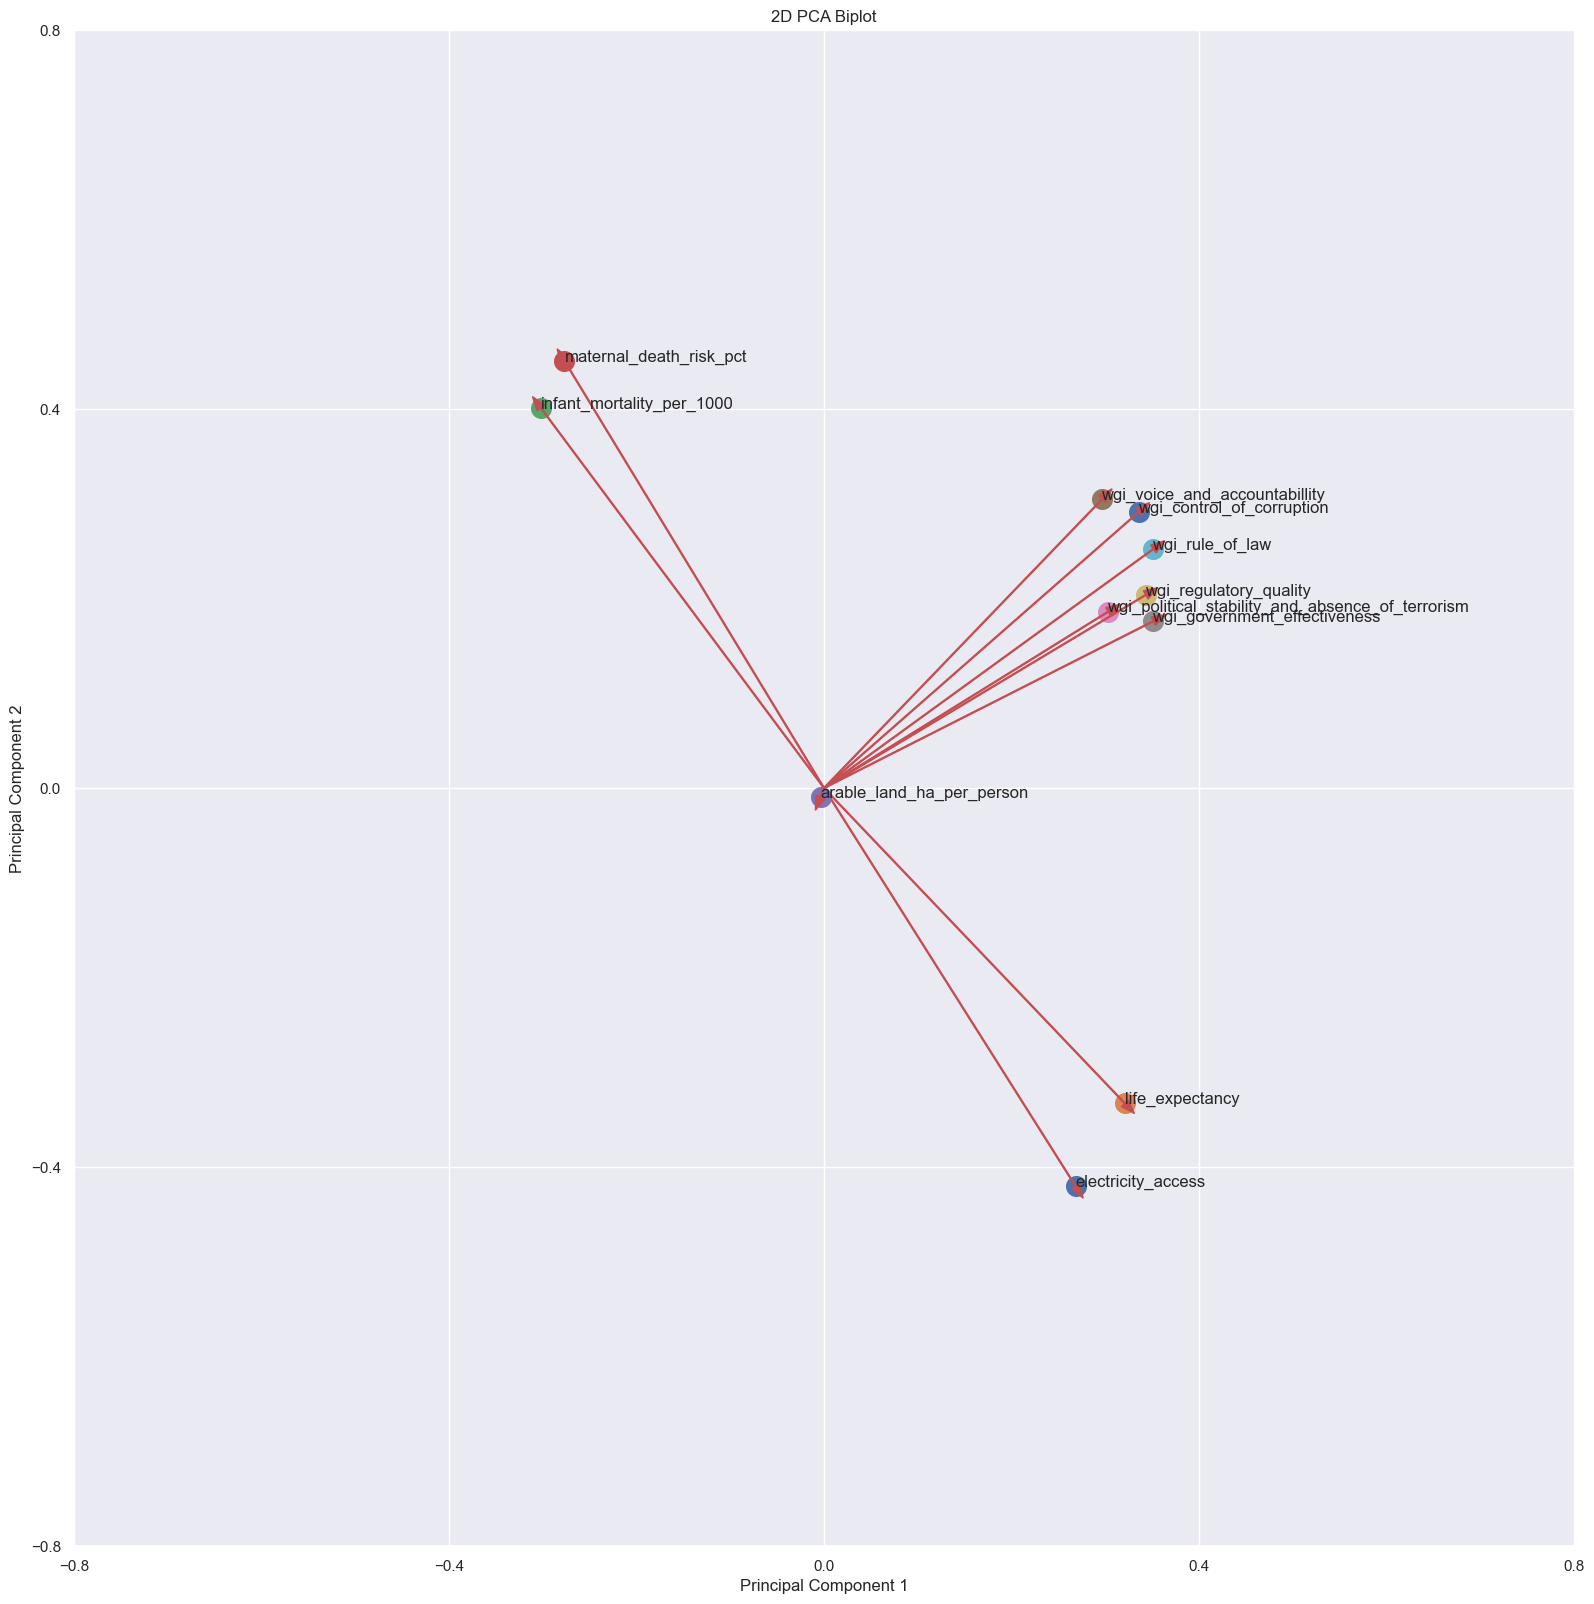

In [81]:
# Modified code from https://www.jcchouinard.com/python-pca-biplots-machine-learning/

loadings_table2 = loadings_table[["PC1", "PC2"]]

# 2D
sns.set()
 
xs = loadings_table2["PC1"]
ys = loadings_table2["PC2"]
 
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=loadings_table2, 
    fit_reg=False, 
    height = 16,
    aspect = 1
    )
 
for i, varnames in enumerate(features):
    plt.scatter(xs.iloc[i], ys.iloc[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs.iloc[i], # length of the arrow along x
        ys.iloc[i], # length of the arrow along y
        color='r', 
        head_width=0.01
        )
    plt.text(xs.iloc[i], ys.iloc[i], varnames)
 
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
 
plt.title('2D PCA Biplot')
plt.show()

### PC1 has moderate and positive relationship with WGI indicators, electricity access and life expectancy. In comparison to infant and maternal mortality, the relationship is moderately negative. Therefore PC1 could be somewhat interpreted as 'overall development, healtchare and institutional quality'. For PC2, Governance variables remain positive but exhibit smaller contributions than in PC1. As for other variables, their relationship is quite the opposite as it is for PC1 (expect for arable land variable as it is around 0 for both components). Therefore it could be considered as dimension of 'Poor electricity infrastructure and high mortality rates'. 

PC3 has weak connections to all variables but one - arable land per person, for which it is almost equal to 1. Other principal components are much more complex, therefore they will not be described.

### A sensible approach to PCA is to choose such an amount of principal components, that will allow for selected variables to explain around 95% of the variance, cumulatively. Therefore, first five principal components will be chosen as new variables for clustering purposes. By using this approach, over 50% of the variables are dropped and almost 94% of variance is explained by the remaining ones.

In [82]:
pca5 = PCA(n_components=5)
x_pca5 = pca5.fit_transform(x_scaled)
pca5_df = pd.DataFrame(x_pca5, columns=[f"PC{i}" for i in range(1, 6)], index=wide.index)
data_pca5 = pd.concat([wide[["Country Name", "Country Code"]], pca5_df], axis=1)


In [83]:
data_pca5

,Country Name,Country Code,PC1,PC2,PC3,PC4,PC5
0,Afghanistan,AFG,-4.919518,-0.238442,0.203724,-1.307932,0.903762
1,Albania,ALB,0.786629,-0.952073,0.213218,0.152150,-0.149909
2,Algeria,DZA,-1.118942,-1.657203,-0.178493,-0.076730,0.271090
3,Andorra,AND,4.010662,0.794214,-0.846943,-0.149638,-0.181206
4,Angola,AGO,-2.749941,0.605184,-0.199969,-0.062667,-0.520761
...,...,...,...,...,...,...,...
179,Vanuatu,VUT,0.346643,0.586587,-0.728586,0.925352,-0.852340
180,Viet Nam,VNM,-0.109968,-1.161863,-0.628459,-0.356098,0.518138
181,West Bank and Gaza,PSE,-0.973054,-1.885087,-0.616160,-1.183343,0.153847
182,Zambia,ZMB,-1.544681,0.745387,-0.132856,0.674398,-0.873218


# Chapter III - Clustering using new variables

## Since PAM clustering was analyzed and discussed the most, clustering using principal components will be done using only this algorithm. As with standard clustering procedure, ample amount of clusters will be chosen.

In [84]:
silhouettes = []
calinski_harabasz_scores = []
dissimilarities = [] 

k_range = range(2, 20)

for k in k_range:
    pam = KMedoids(n_clusters=k, method="pam", metric="euclidean", init="k-medoids++", random_state=111)
    labels = pam.fit_predict(pca5_df)

    silhouettes.append(silhouette_score(pca5_df, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(pca5_df, labels))
    dissimilarities.append(pam.inertia_)

Text(0.5, 1.0, 'Elbow curve for PAM (PCA)')

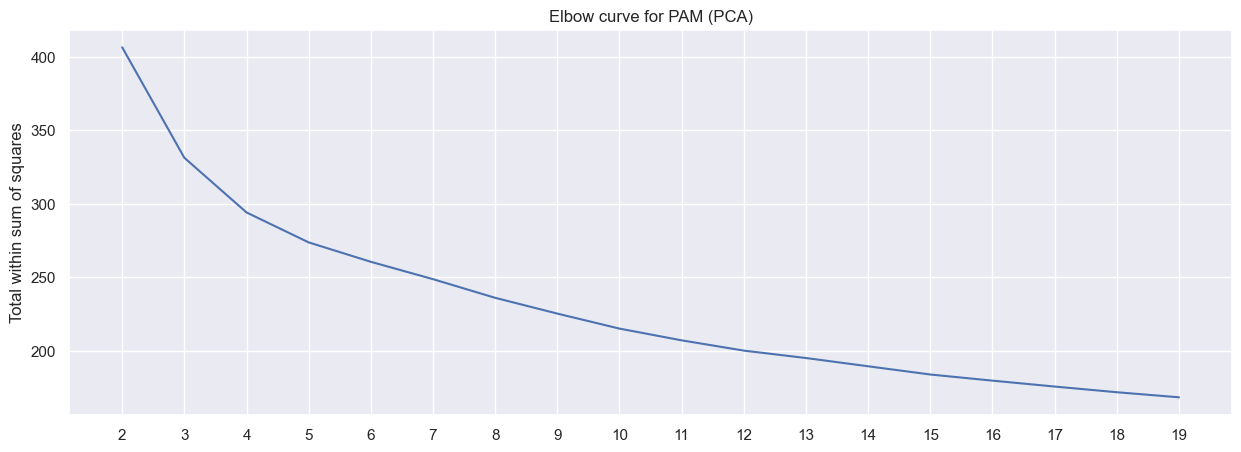

In [85]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), dissimilarities)
plt.ylabel("Total within sum of squares")
plt.xticks(k_range)
plt.grid(True)
plt.title('Elbow curve for PAM (PCA)')

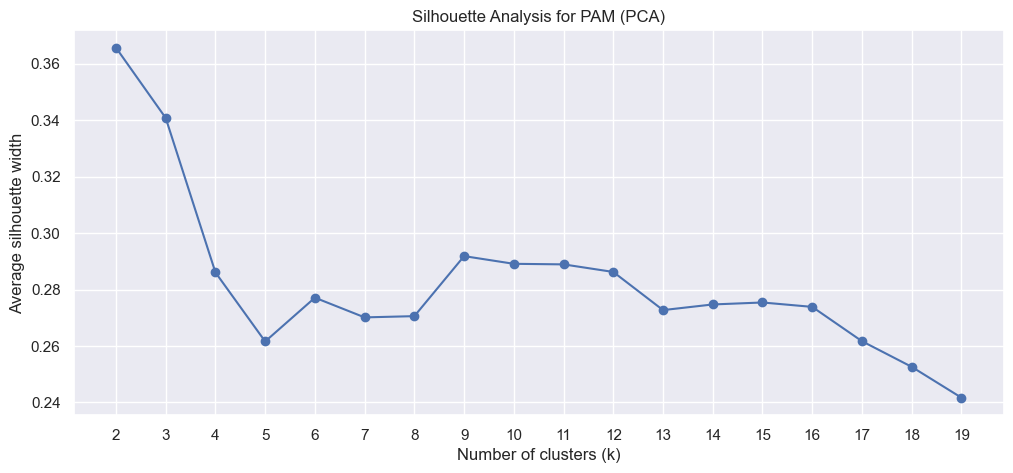

In [86]:
plt.figure(figsize=(12, 5))
plt.plot(k_range, silhouettes, marker='o')
plt.xticks(k_range)    
plt.grid(True)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average silhouette width")
plt.title("Silhouette Analysis for PAM (PCA)")
plt.show()

In [87]:
for k, val in zip(k_range, silhouettes):
    print(f"k = {k}: Average silhouette width = {val}")

k = 2: Average silhouette width = 0.3656423554361297
k = 3: Average silhouette width = 0.3407447205633269
k = 4: Average silhouette width = 0.2860442809772131
k = 5: Average silhouette width = 0.26159474193660737
k = 6: Average silhouette width = 0.277102863376047
k = 7: Average silhouette width = 0.2701245368824029
k = 8: Average silhouette width = 0.27056573170669884
k = 9: Average silhouette width = 0.29182099688095237
k = 10: Average silhouette width = 0.28909764514043124
k = 11: Average silhouette width = 0.2888989527396384
k = 12: Average silhouette width = 0.28621308480205443
k = 13: Average silhouette width = 0.2727058213446365
k = 14: Average silhouette width = 0.27470567878793456
k = 15: Average silhouette width = 0.27540195040698023
k = 16: Average silhouette width = 0.27384567118315195
k = 17: Average silhouette width = 0.26169311748689184
k = 18: Average silhouette width = 0.2526126586444376
k = 19: Average silhouette width = 0.24169330387085167


In [88]:
for k, val in zip(k_range, calinski_harabasz_scores):
    print(f"k = {k}: Calinski-Harabasz index = {val}")

k = 2: Calinski-Harabasz index = 138.46459082997498
k = 3: Calinski-Harabasz index = 134.57147506939796
k = 4: Calinski-Harabasz index = 115.13148271736499
k = 5: Calinski-Harabasz index = 103.14859275996
k = 6: Calinski-Harabasz index = 96.01593449093518
k = 7: Calinski-Harabasz index = 85.9462059401639
k = 8: Calinski-Harabasz index = 91.63014197407341
k = 9: Calinski-Harabasz index = 94.30682671378463
k = 10: Calinski-Harabasz index = 91.1161946069852
k = 11: Calinski-Harabasz index = 99.87180621725489
k = 12: Calinski-Harabasz index = 99.02179904915984
k = 13: Calinski-Harabasz index = 97.24778656337196
k = 14: Calinski-Harabasz index = 94.50201900602838
k = 15: Calinski-Harabasz index = 93.12374339073246
k = 16: Calinski-Harabasz index = 90.93258239121661
k = 17: Calinski-Harabasz index = 87.89693580098444
k = 18: Calinski-Harabasz index = 84.70668430302338
k = 19: Calinski-Harabasz index = 81.85424702344035


## Once again, k = 3 seems most sensible. Not only is the 'elbow' visible for such amount of clusters, Calinski-Harabasz index is second highest (with not being far away from the highest at k = 2), but most importantly, the same amount of clusters is needed for a meaningful analysis and comparison.

In [89]:
pam_pca_final = KMedoids(n_clusters=3, method="pam", metric="euclidean", random_state=111)
labels_pam_pca = pam_final.fit_predict(pca5_df)
wide["cluster_pam_pca"] = labels_pam_pca

Clustering quality measure| PAM (k = 3, PCA) | PAM (k = 3) 
|---|---|---|
| Average silhouette index  | 0.34  | 0.301  |
| Calinski-Harabasz index  | 134.57  | 114.996  |

In [90]:
ari_pam_pca_pam = adjusted_rand_score(wide["cluster_pam_pca"],wide["cluster_pam"])

print("Adjusted Rand Index (PAM (PCA) vs PAM):", ari_pam_pca_pam)

Adjusted Rand Index (PAM (PCA) vs PAM): 0.964089170492266


## Average silhouette and Calinski Harabasz indexes are higher for PAM clustering using PCA. Clustering results are very simillar - as adjusted rand index at 0.96 suggests.


In [91]:
pam_map_pca = {
    2: 2,
    1: 3,
    0: 1
}

wide["cluster_pam_pca"] = wide["cluster_pam_pca"].map(pam_map_pca)

In [92]:
wide

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo,cluster_pam_pca
0,Afghanistan,AFG,0.192465,-1.183684,85.3,-1.880035,-2.544956,-1.659846,-1.271806,2.667380,52.0,65.617,-1.753529,3,3,2,3
1,Albania,ALB,0.243960,-0.408189,100.0,0.064541,0.106261,-0.165585,0.159354,0.010570,8.3,78.769,0.141740,2,2,1,2
2,Algeria,DZA,0.165599,-0.638041,100.0,-0.513499,-0.650652,-0.833260,-1.063573,0.169461,20.0,76.129,-1.011919,2,2,2,2
3,Andorra,AND,0.009380,1.270272,100.0,1.495261,1.585988,1.485483,1.398334,0.014257,2.6,84.016,1.106789,1,1,1,1
4,Angola,AGO,0.151115,-0.612376,48.5,-1.026034,-0.630109,-1.022036,-0.606699,0.966423,39.6,64.246,-0.807578,3,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Vanuatu,VUT,0.063888,-0.028580,71.6,-0.538525,0.961862,0.322184,-0.090816,0.397198,14.4,71.302,0.585711,2,2,1,2
180,Viet Nam,VNM,0.067746,-0.287254,100.0,0.174635,-0.046132,-0.158469,-0.429956,0.083527,14.3,74.502,-1.286407,2,2,1,2
181,West Bank and Gaza,PSE,0.008308,-0.702708,100.0,-0.902029,-1.701955,-0.555172,-0.036869,0.059103,12.3,76.662,-1.035614,2,2,2,2
182,Zambia,ZMB,0.188558,-0.504948,47.8,-0.638017,0.161332,-0.517024,-0.529058,0.384520,32.2,65.279,-0.079451,2,3,2,3


In [93]:
world_clusters_pam_and_pca = world_dissolved.merge(
    wide[["Country Code", "cluster_pam", "cluster_pam_pca"]],
    how="left",
    left_on="iso3",
    right_on="Country Code"
)

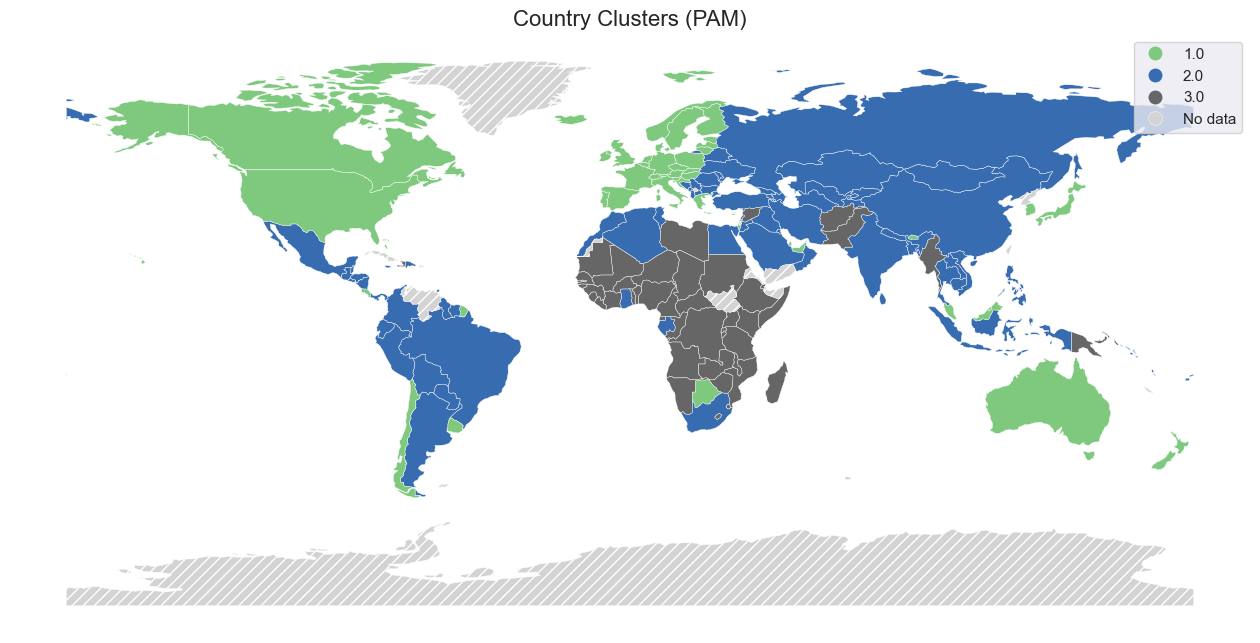

In [94]:
fig, ax = plt.subplots(figsize=(16, 8))

world_clusters.plot(
    column="cluster_pam",
    categorical=True,
    legend=True,
    ax=ax,
    cmap="Accent",
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    edgecolor="white",
    linewidth=0.3
)

ax.set_title("Country Clusters (PAM)", fontsize=16)
ax.set_axis_off()
plt.show()

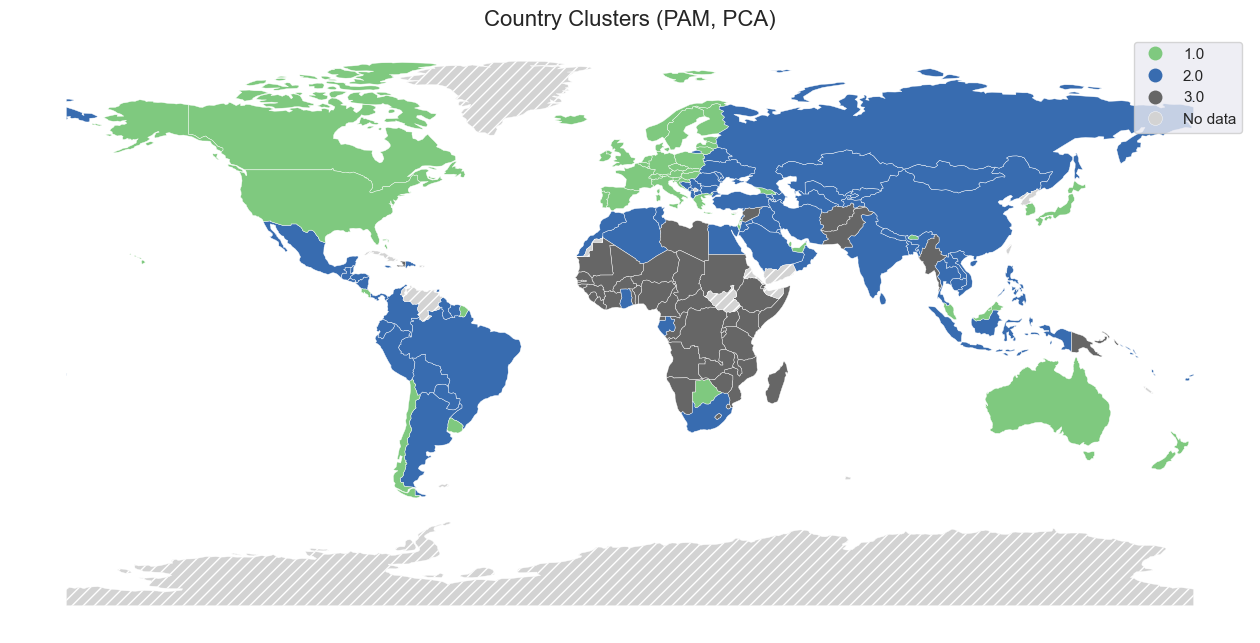

In [95]:
fig, ax = plt.subplots(figsize=(16, 8))

world_clusters_pam_and_pca.plot(
    column="cluster_pam_pca",
    categorical=True,
    legend=True,
    ax=ax,
    cmap="Accent",
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    edgecolor="white",
    linewidth=0.3
)

ax.set_title("Country Clusters (PAM, PCA)", fontsize=16)
ax.set_axis_off()
plt.show()

## At first glance of the world map divided by clusters, it seems like nothing has changed. This implies that dimension reduction was a success, as by removing 6 out of 11 variables it was possible to achieve almost identical results. To be certain, manual check has to be performed.

In [96]:
wide[wide["cluster_pam_pca"] != wide["cluster_pam"]]

Series Code,Country Name,Country Code,arable_land_ha_per_person,wgi_control_of_corruption,electricity_access,wgi_government_effectiveness,wgi_political_stability_and_absence_of_terrorism,wgi_rule_of_law,wgi_regulatory_quality,maternal_death_risk_pct,infant_mortality_per_1000,life_expectancy,wgi_voice_and_accountabillity,cluster_kmeans,cluster_pam,cluster_agglo,cluster_pam_pca
61,Georgia,GEO,0.085118,0.620420,100.0,0.650143,-0.436530,0.169469,1.032309,0.033799,8.1,74.141,0.01564,1,2,1,1
86,Kiribati,KIR,0.015329,0.236452,94.4,0.166980,1.103848,0.625912,-0.261826,0.272680,40.6,66.269,1.09145,1,2,1,1


In [97]:
wide[features].describe()

Series Code,electricity_access,life_expectancy,infant_mortality_per_1000,maternal_death_risk_pct,arable_land_ha_per_person,wgi_voice_and_accountabillity,wgi_political_stability_and_absence_of_terrorism,wgi_government_effectiveness,wgi_regulatory_quality,wgi_rule_of_law,wgi_control_of_corruption
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,86.521196,72.437435,19.984239,0.444675,0.191609,-0.022392,-0.084721,-0.053966,-0.041983,-0.047843,-0.054274
std,23.585344,7.989915,21.265126,0.810218,0.224966,0.971181,0.962735,0.952824,0.937209,0.957007,0.983686
min,10.300000,18.818000,1.400000,0.001167,0.000099,-1.946265,-2.776898,-2.228161,-2.089348,-2.287279,-1.792611
25%,84.400000,67.404750,5.075000,0.018239,0.059255,-0.854022,-0.629996,-0.765052,-0.714083,-0.757770,-0.767299
50%,100.000000,73.417000,13.200000,0.090092,0.119383,0.021517,-0.018716,-0.106993,-0.150161,-0.162027,-0.297659
75%,100.000000,77.506152,30.900000,0.410638,0.232642,0.849697,0.727070,0.566299,0.551190,0.630636,0.565911
max,100.000000,85.708000,189.100000,4.528834,1.480922,1.780675,1.585988,2.144236,2.214378,1.957900,2.402638


## Only 2 countries were grouped differently in the PAM clustering using PCA to the one without. Georgia ended up in cluster 1 (same case as when discussing PAM vs K-means). Kiribati was also assigned to the first cluster. Most likely due to high in some, and higher than 'dataset global' average for the rest, values of political and institutional performance indicators. For health related performance variables however, their performance is rather poor. Therefore I believe PAM clustering using PCA is slightly worse, as those countries should rather be included in cluster 2.

# Chapter II - Summary

Goal of this chapter was to perform dimensional reduction on the original dataset, in order to perform clustering and compare the results with groupings created in Chapter 1. In order to perform dimension reduction, PCA was applied. In order to define what should be the amount of used principal components, analysis was performed.

Overview of charts and tables displaying cumulative explained variance, principal component's eigenvectors and loadings led to a conclusion, that first five out of eleven principal components should be used. By doing so, 94% of the variance was explained by less than half of the original variables. Clustering using the PAM algorithm with transformed data by PCA yields simillar results to PAM clustering without PCA, as only two countries were assigned different groups. Such results imply the conclusion that in this case, PCA is an excellent approach to dimension reduction - as with minimal amount of values almost identical clustering results were achieved.

# Project Conclusion

Based on the clustering results, and thus in response to the research question, countries most likely to require aid are predominantly located in Africa, the Middle East, and Southern and Central Asia.

With regard to cluster 3 identified by the PAM algorithm, all countries within this group may be considered highly eligible for assistance. Nevertheless, several countries stand out in specific dimensions:

- in the terms of humanitarian aid and healthcare development - Central African Republic, Nigeria, Chad and Somalia
- in the terms of access to electricity: Burundi, Chad, Malawi and Central African Republic
- in terms of political and institutional performance: Syria, Somalia and Libya.

However, it is important to note that countries belonging to cluster 2, while not exhibiting severe deficiencies in the healthcare dimension, perform poorly in terms of political and institutional quality. In several cases, their governance outcomes are comparable to those observed in the lowest performing countries of cluster 3. In particular, Turkmenistan, Tajikistan, Iraq, and Iran consistently rank among the weakest performers, appearing most frequently in the bottom five positions across governance indicators. Belarus and Nicaragua may also be included in this group, as they were also present in more than one of the worst institutional performance analysis tables.

Overall, each of these countries appears among the lowest performers in at least two of the six World Governance Indicators, indicating persistent institutional weaknesses despite relatively better performance in other development dimensions.

Political dimension performance is also the hardest dimension in which aid may be provided - as factors like corruption are not just something that may be solved with proper funding, like it is the case with healthcare. However, one approach could suggest that this may be done by reforming and auditing the political institutions, and then funding and advising them. This is a very complex issue, but as for financial aid in this area, that could be one of the ways that it could be implemented.

Similar grouping results for the PAM clustering algorithm may be achieved with dimension reduction by applying PCA, selecting only 5 principal components and performing the clustering. Only two countries were mismatched, in comparison to PAM clustering on untransformed data.